In [5]:
library("here")
library(devtools)
library(Seurat)
library(harmony)
library(RcppML)


load_all('/home/jpm73279/Socrates')
data_path <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/QC_output/"

ℹ Loading Socrates
Warning message:
"replacing previous import 'scales::viridis_pal' by 'viridis::viridis_pal' when loading 'Socrates'"


In [6]:
rep_1 <- paste0(data_path,"Sb.Leaf_rep1.QC_v2_QC_soc_obj.rds")
rep_2 <- paste0(data_path,"Sb.Leaf_rep2.QC_v2_soc_obj.rds")
prefix <- "Sb_leaf.merged_replicates.V2"
#PDF_dir <- "PDF_outputs"
#dir.create(PDF_dir)

rep_1_read <- readRDS(rep_1)
rep_2_read <- readRDS(rep_2)
rep_files <- list(rep_1_read, rep_2_read)
names(rep_files) <- c("rep1", "rep2")


print("Merging Object")
merged.obj <- mergeSocratesRDS(obj.list=rep_files)


print("Generating Socrates Obj")
    ## Generate Socrates Object
soc.obj <- merged.obj




[1] "Merging Object"
[1] "Generating Socrates Obj"


In [7]:
    print("Generating Graphs")
    # estimate log10 number of accessible regions per cell
    cell.counts <- Matrix::colSums(soc.obj$counts)

    # estimate peak accessibility frequency across cells
    site.freq <- Matrix::rowMeans(soc.obj$counts)

[1] "Generating Graphs"


Warning message in xy.coords(x, y, xlabel, ylabel, log):
"4 x values <= 0 omitted from logarithmic plot"


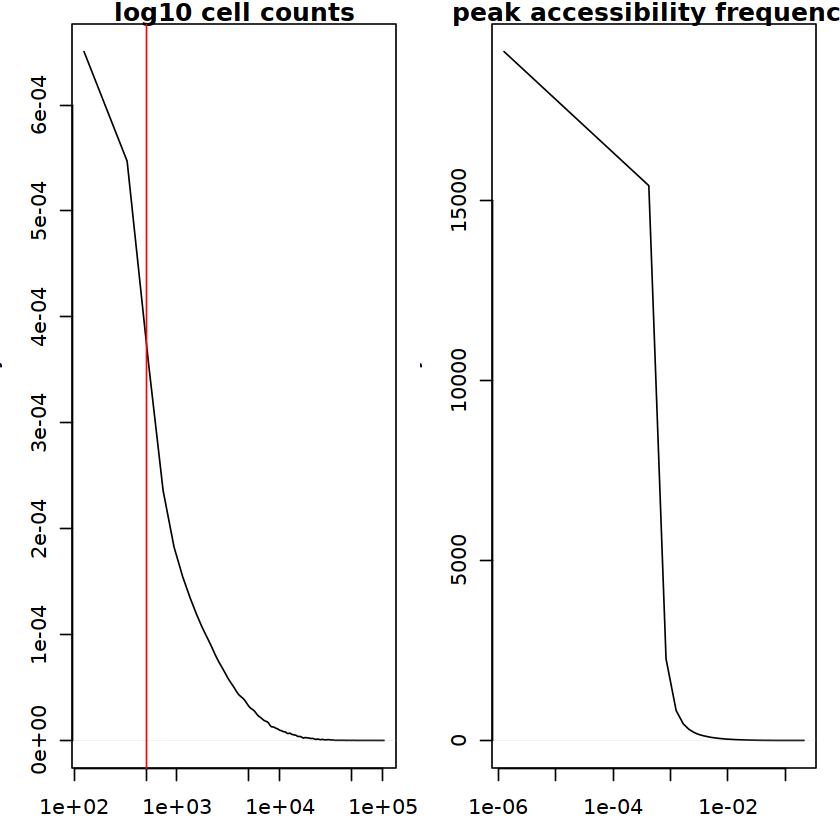

In [8]:
layout(matrix(c(1:2), ncol=2))
par(mar=c(3,3,1,1))
plot(density(cell.counts), main="log10 cell counts", log="x")
abline(v=500, col="red")
plot(density(site.freq), main="peak accessibility frequency", log="x")

In [9]:
# get per cell feature counts --------------------------------------------
cell.counts <- Matrix::colSums(soc.obj$counts)  # count number of features with Tn5 insertions per cell
cell.counts.z <- as.numeric(scale(cell.counts)) # convert features counts into Z-scores
cell.counts.threshold <- max(c(cell.counts[cell.counts.z < -1], 100)) # minimum feature counts (greater of 1 std or 1000)


# clean sparse counts matrix ---------------------------------------------
soc.obj <- cleanData(soc.obj, 
                     min.c=200,  # minimum number of accessible features per cell
                     min.t=0.001,  # minimum feature frequency across cells
                     max.t=0.01, # maximum feature frequency across cells
                     verbose=T)

   * Input: cells = 34199 | peaks = 2439277

   * Filtered: cells = 20064 | peaks = 239980



In [10]:
# normalize with TFIDF ---------------------------------------------------
soc.obj <- tfidf(soc.obj)

In [11]:
# project with NMF -------------------------------------------------------
soc.obj <- reduceDims(soc.obj,
                      method="SVD", 
                      n.pcs=30, 
                      num.var=5000,
                      svd_slotName="SVD")


# reduce to 2-dimensions with UMAP ---------------------------------------
soc.obj <- projectUMAP(soc.obj, 
                       verbose=T,
                       k.near=15,
                       m.dist=0.01,
                       svd_slotName="SVD")

 - non-linear dimensionality reduction with UMAP ...

08:41:17 UMAP embedding parameters a = 1.896 b = 0.8006

08:41:17 Read 20064 rows and found 30 numeric columns

08:41:17 Using Annoy for neighbor search, n_neighbors = 15

08:41:17 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

08:41:19 Writing NN index file to temp file /tmp/RtmpU7Bk9j/file1938d5451555e

08:41:19 Searching Annoy index using 16 threads, search_k = 1500

08:41:20 Annoy recall = 100%

08:41:23 Commencing smooth kNN distance calibration using 16 threads
 with target n_neighbors = 15

08:41:26 Initializing from normalized Laplacian + noise (using irlba)

08:41:26 Commencing optimization for 200 epochs, with 492826 positive edges

08:41:55 Optimization finished



In [12]:
tfidf.obj.dob <- detectDoublets(soc.obj, threads=15, nTrials=5, 
                                nSample=2000, rdMethod = "SVD", svd_slotName="SVD")

 - Creating synthetic doublets ...

Warning message in mclapply(seq_len(nTrials), function(y) {:
"scheduled cores 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15 did not deliver results, all values of the jobs will be affected"
 - Created 14000 synthetic doublets ...

 - Creating original projection ...

 - Merging synthetic and original cells ...

 - Projecting to UMAP ...

 - Computing KNN doublets (SVD)...

 - Computing KNN doublets (UMAP)...



In [13]:
tfidf.obj.dob.filt <- filterDoublets(obj=tfidf.obj.dob, 
                                     filterRatio=1.0, 
                                     removeDoublets=FALSE, 
                                     libraryVar="sampleID",
                                     verbose=TRUE)

 - libraryVar: sampleID



In [14]:
prcnt_to_remove <- 96 - (96*((1-(1/96))^25)) - (25*((1-(1/96))**24))
prcnt_to_remove

[1] 2.666365

In [15]:
prcnt_to_remove <- 96 - (96*((1-(1/96))^25)) - (25*((1-(1/96))**24))
calculated_value <- (100 - prcnt_to_remove)/100
remove_val_greater <- sort(tfidf.obj.dob.filt$meta$doubletscore)[calculated_value*length(tfidf.obj.dob.filt$meta$doubletscore)]

── Attaching packages ───────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
✔ purrr   0.3.4      
Warning message:
"package 'tibble' was built under R version 4.2.1"
Warning message:
"package 'purrr' was built under R version 4.2.1"
Warning message:
"package 'stringr' was built under R version 4.2.1"
── Conflicts ──────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::accumulate() masks foreach::accumulate()
✖ readr::col_factor() masks Socrates::col_factor(), scales::col_factor()
✖ dplyr::collapse()   masks IRanges::collapse()
✖ dplyr::combine()    masks Biobase::combine(), BiocGenerics::combine()
✖ dplyr::count()      masks matrixStats::count()
✖ dplyr::desc()       masks IRanges::desc()
✖ purrr::discard()    masks Socrates::discard(), scales::discard()
✖ tidyr::expand()     masks Socrates::expand(), S4Vectors::expand(), Matrix::expand()
✖ dpl

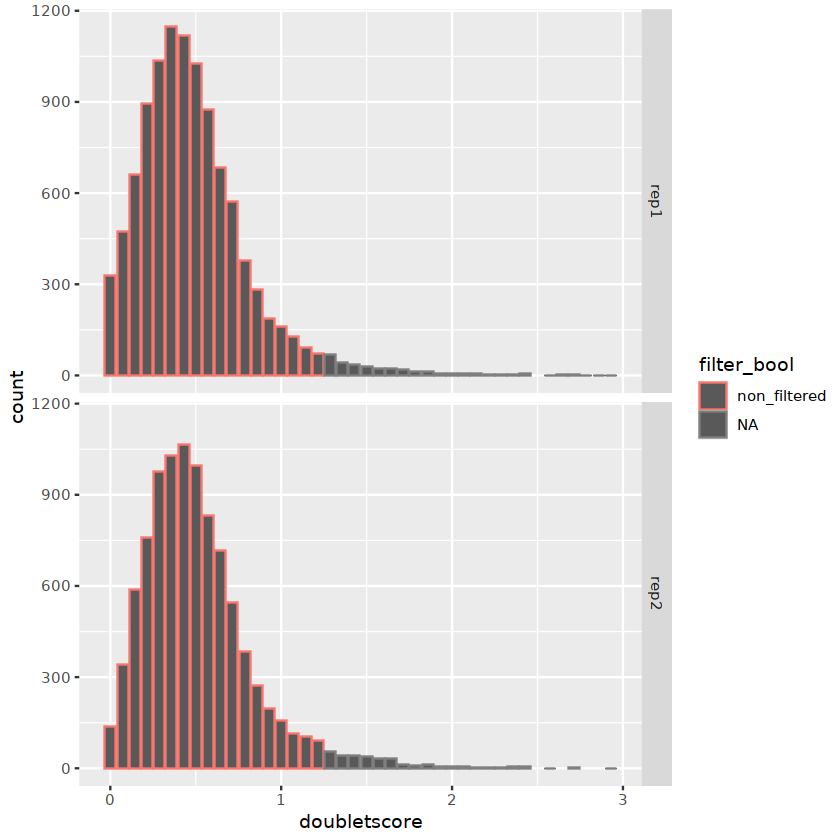

In [16]:
library(tidyverse)
as_tibble(tfidf.obj.dob.filt$meta) %>% 
    mutate(filter_bool = case_when(doubletscore < remove_val_greater ~ "non_filtered",
             doubletscore < remove_val_greater ~ "filtered"))  %>% 
    ggplot(., aes(doubletscore, color = filter_bool)) + geom_bar() + facet_grid(sampleID~.)

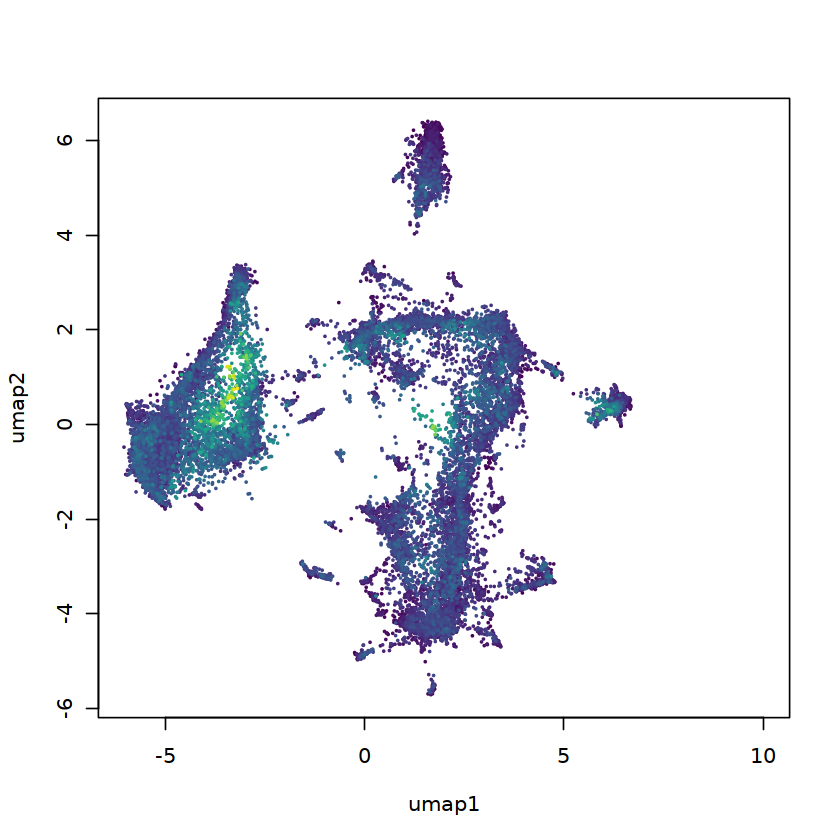

In [17]:
plotUMAP(tfidf.obj.dob.filt, cex=0.3, column = "doubletscore")

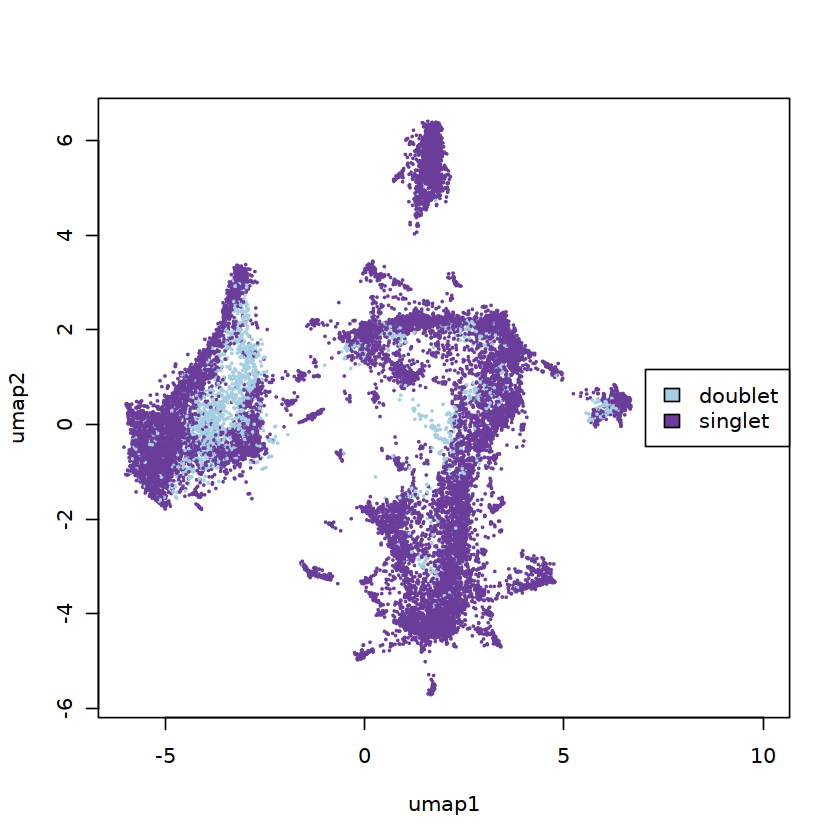

In [18]:
plotUMAP(tfidf.obj.dob.filt, cex=0.3, column = "d.type")

In [19]:
library(tidyverse)
remove_top_x_doublet_percent <- function(obj) { 
    prcnt_to_remove <- 96 - (96*((1-(1/96))^25)) - (25*((1-(1/96))**24))
    calculated_value <- (100 - prcnt_to_remove)/100
    
    old_meta <- obj$meta
    remove_val_greater <- sort(old_meta$doubletscore)[calculated_value*length(old_meta$doubletscore)]
    
    grabbed_graph <- as_tibble(obj$meta) %>% 
        mutate(filter_bool = case_when(doubletscore < remove_val_greater ~ "non_filtered",
                                       doubletscore > remove_val_greater ~ "filtered"))  %>% 
        ggplot(., aes(doubletscore, color = filter_bool)) + geom_bar() + facet_grid(sampleID~.)
    
    new_meta <- subset(old_meta, doubletscore < calculated_value) 
    removed_cells <- nrow(old_meta) - nrow(new_meta)
    new_meta$d.type <- "singlet"
    
    obj$pre.doublet.meta <- old_meta
    obj$meta <- new_meta
    obj$counts <- obj$counts[,rownames(obj$meta)]
    obj$counts <- obj$count[Matrix::rowSums(obj$counts)>0,]
    obj$counts <- obj$count[,Matrix::colSums(obj$counts)>0]
    obj[["UMAP"]] <- obj[["UMAP"]][colnames(obj$counts),]
    obj[["PCA"]] <- obj[["PCA"]][colnames(obj$counts),]
    new.num.cells <- ncol(obj$counts)
    message("   * Doublet filtering * Number cells removed= ", removed_cells,"  Filtered: cells = ", ncol(obj$counts), " | peaks = ", nrow(obj$counts))

    
    return(obj)

}

plot_top_x_doublet_percent <- function(obj) { 
    prcnt_to_remove <- 96 - (96*((1-(1/96))^25)) - (25*((1-(1/96))**24))
    calculated_value <- (100 - prcnt_to_remove)/100
    
    old_meta <- obj$meta
    remove_val_greater <- sort(old_meta$doubletscore)[calculated_value*length(old_meta$doubletscore)]
    
    grabbed_graph <- as_tibble(obj$meta) %>% 
        mutate(filter_bool = case_when(doubletscore < remove_val_greater ~ "non_filtered",
                                       doubletscore > remove_val_greater ~ "filtered")) 

    
    return(grabbed_graph)

}

In [20]:
tfidf.obj.dob.filt.removed.graph <- plot_top_x_doublet_percent(tfidf.obj.dob.filt)
head(tfidf.obj.dob.filt.removed.graph)

cellID                                                     total  tss   
1 BC:Z:ATCACGGGCTACGTATAACTGATACCG-Sorghum_leaf.sciATAC_rep1 158695  40497
2 BC:Z:CGATGTAGTCAACTAAGATTCCTACCG-Sorghum_leaf.sciATAC_rep1 159913  50096
3 BC:Z:GCCAATATGTCACTAAGGGTAGCACTA-Sorghum_leaf.sciATAC_rep1 193728 115477
4 BC:Z:TTAGGCAGTCAACAAAAGGTAGCGTTT-Sorghum_leaf.sciATAC_rep1 109649  27618
5 BC:Z:ACAGTGCCGTCCCTAAGGTAGAGAGCT-Sorghum_leaf.sciATAC_rep1 116717  44610
6 BC:Z:TTAGGCAGTCAAAAACACGTACGTCGG-Sorghum_leaf.sciATAC_rep1 137825  80881
  acrs   ptmt nSites log10nSites pTSS      FRiP       pOrg        ⋯ qc_check
1  15532  710 102298 5.009867    0.2551876 0.09787328 0.004473991 ⋯ 0       
2  29062 1554  98398 4.992986    0.3132703 0.18173632 0.009717784 ⋯ 0       
3 153521 4732  75091 4.875588    0.5960780 0.79245643 0.024425999 ⋯ 1       
4  11343  318  71779 4.855997    0.2518764 0.10344828 0.002900163 ⋯ 0       
5  44302  998  68519 4.835811    0.3822065 0.37956767 0.008550597 ⋯ 1       
6  99059 1829  62308 4.794544    0.5868384 0.71873027 0.013270452 ⋯ 1       
  background cellbulk   is_cell sampleID umap1     umap2      doubletscore
1 0.02425779 0.09063446 1       rep1      1.536805  5.7093573 0.5000000   
2 0.03645688 0.14445624 1       rep1      1.536760  4.9014068 0.4285714   
3 0.05997227 0.27484816 1       rep1     -3.268338  0.9765269 2.6428571   
4 0.02589089 0.08884953 1       rep1      1.699009  5.8412280 0.2142857   
5 0.05824980 0.25990915 1       rep1     -3.682250 -0.2006121 1.0000000   
6 0.05266560 0.24570416 1       rep1     -2.906097  1.3383558 1.6428571   
  d.type  filter_bool 
1 singlet non_filtered
2 singlet non_filtered
3 doublet filtered    
4 singlet non_filtered
5 doublet non_filtered
6 doublet filtered

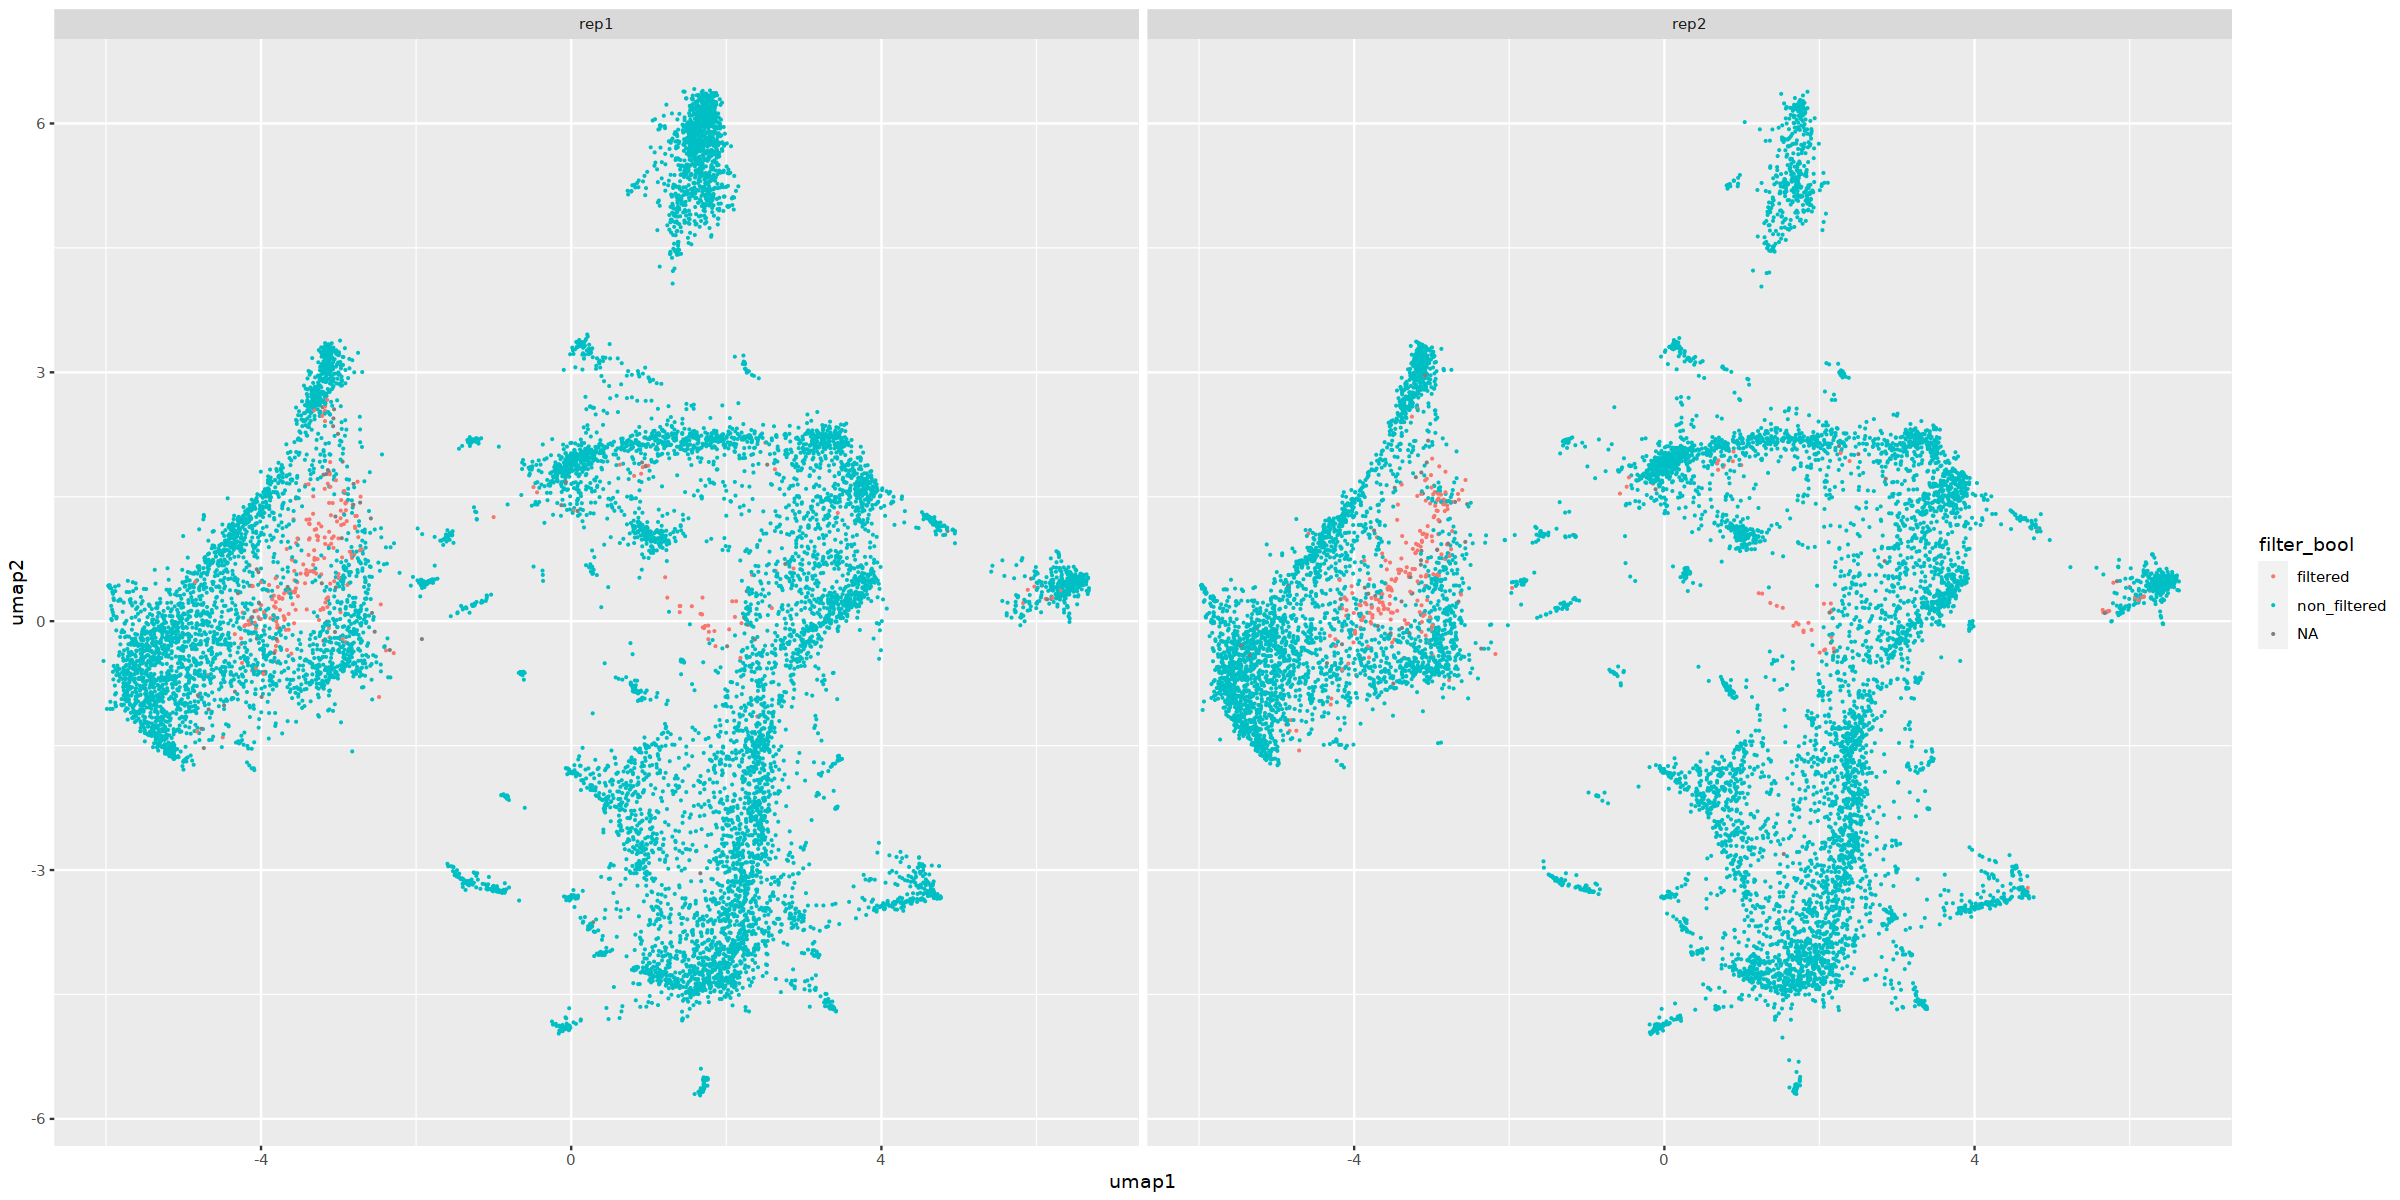

In [21]:
options(repr.plot.width=20, repr.plot.height=10)
ggplot(tfidf.obj.dob.filt.removed.graph ,aes(umap1, umap2, color = filter_bool)) + 
    geom_jitter(size = .1) + facet_grid(.~sampleID)

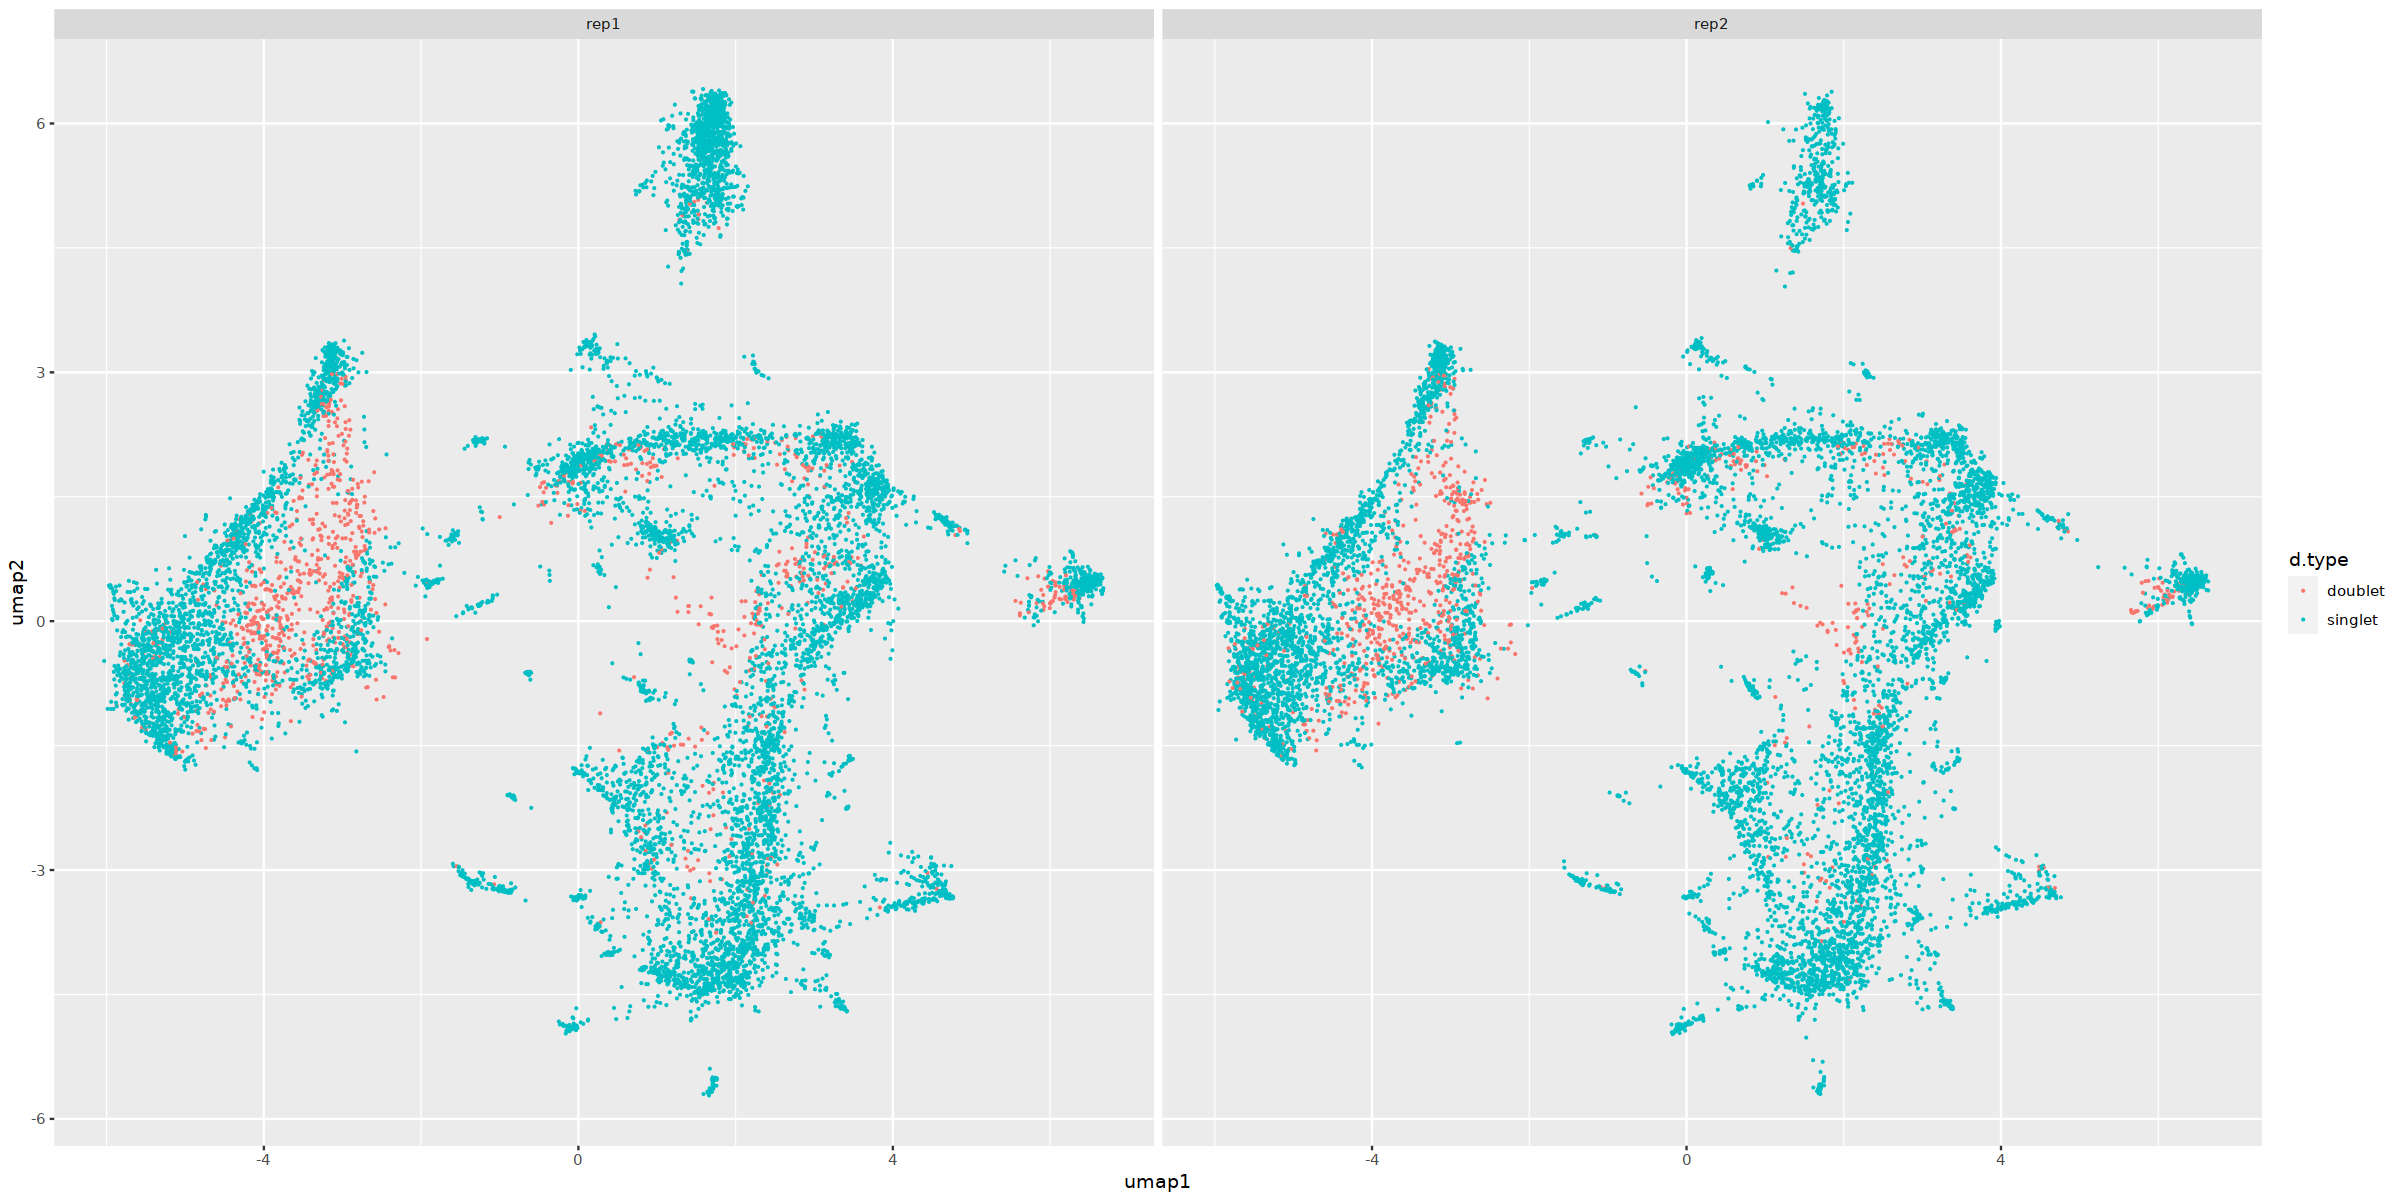

In [22]:
options(repr.plot.width=20, repr.plot.height=10)
ggplot(tfidf.obj.dob.filt.removed.graph ,aes(umap1, umap2, color = d.type)) + 
    geom_jitter(size = .1) + facet_grid(.~sampleID)

In [23]:
unique(tfidf.obj.dob.filt.removed.graph$data$filter_bool)

Warning message:
"Unknown or uninitialised column: `data`."


NULL

In [24]:
tfidf.obj.dob.filt.removed <- remove_top_x_doublet_percent(tfidf.obj.dob.filt)

   * Doublet filtering * Number cells removed= 1551  Filtered: cells = 18513 | peaks = 239980



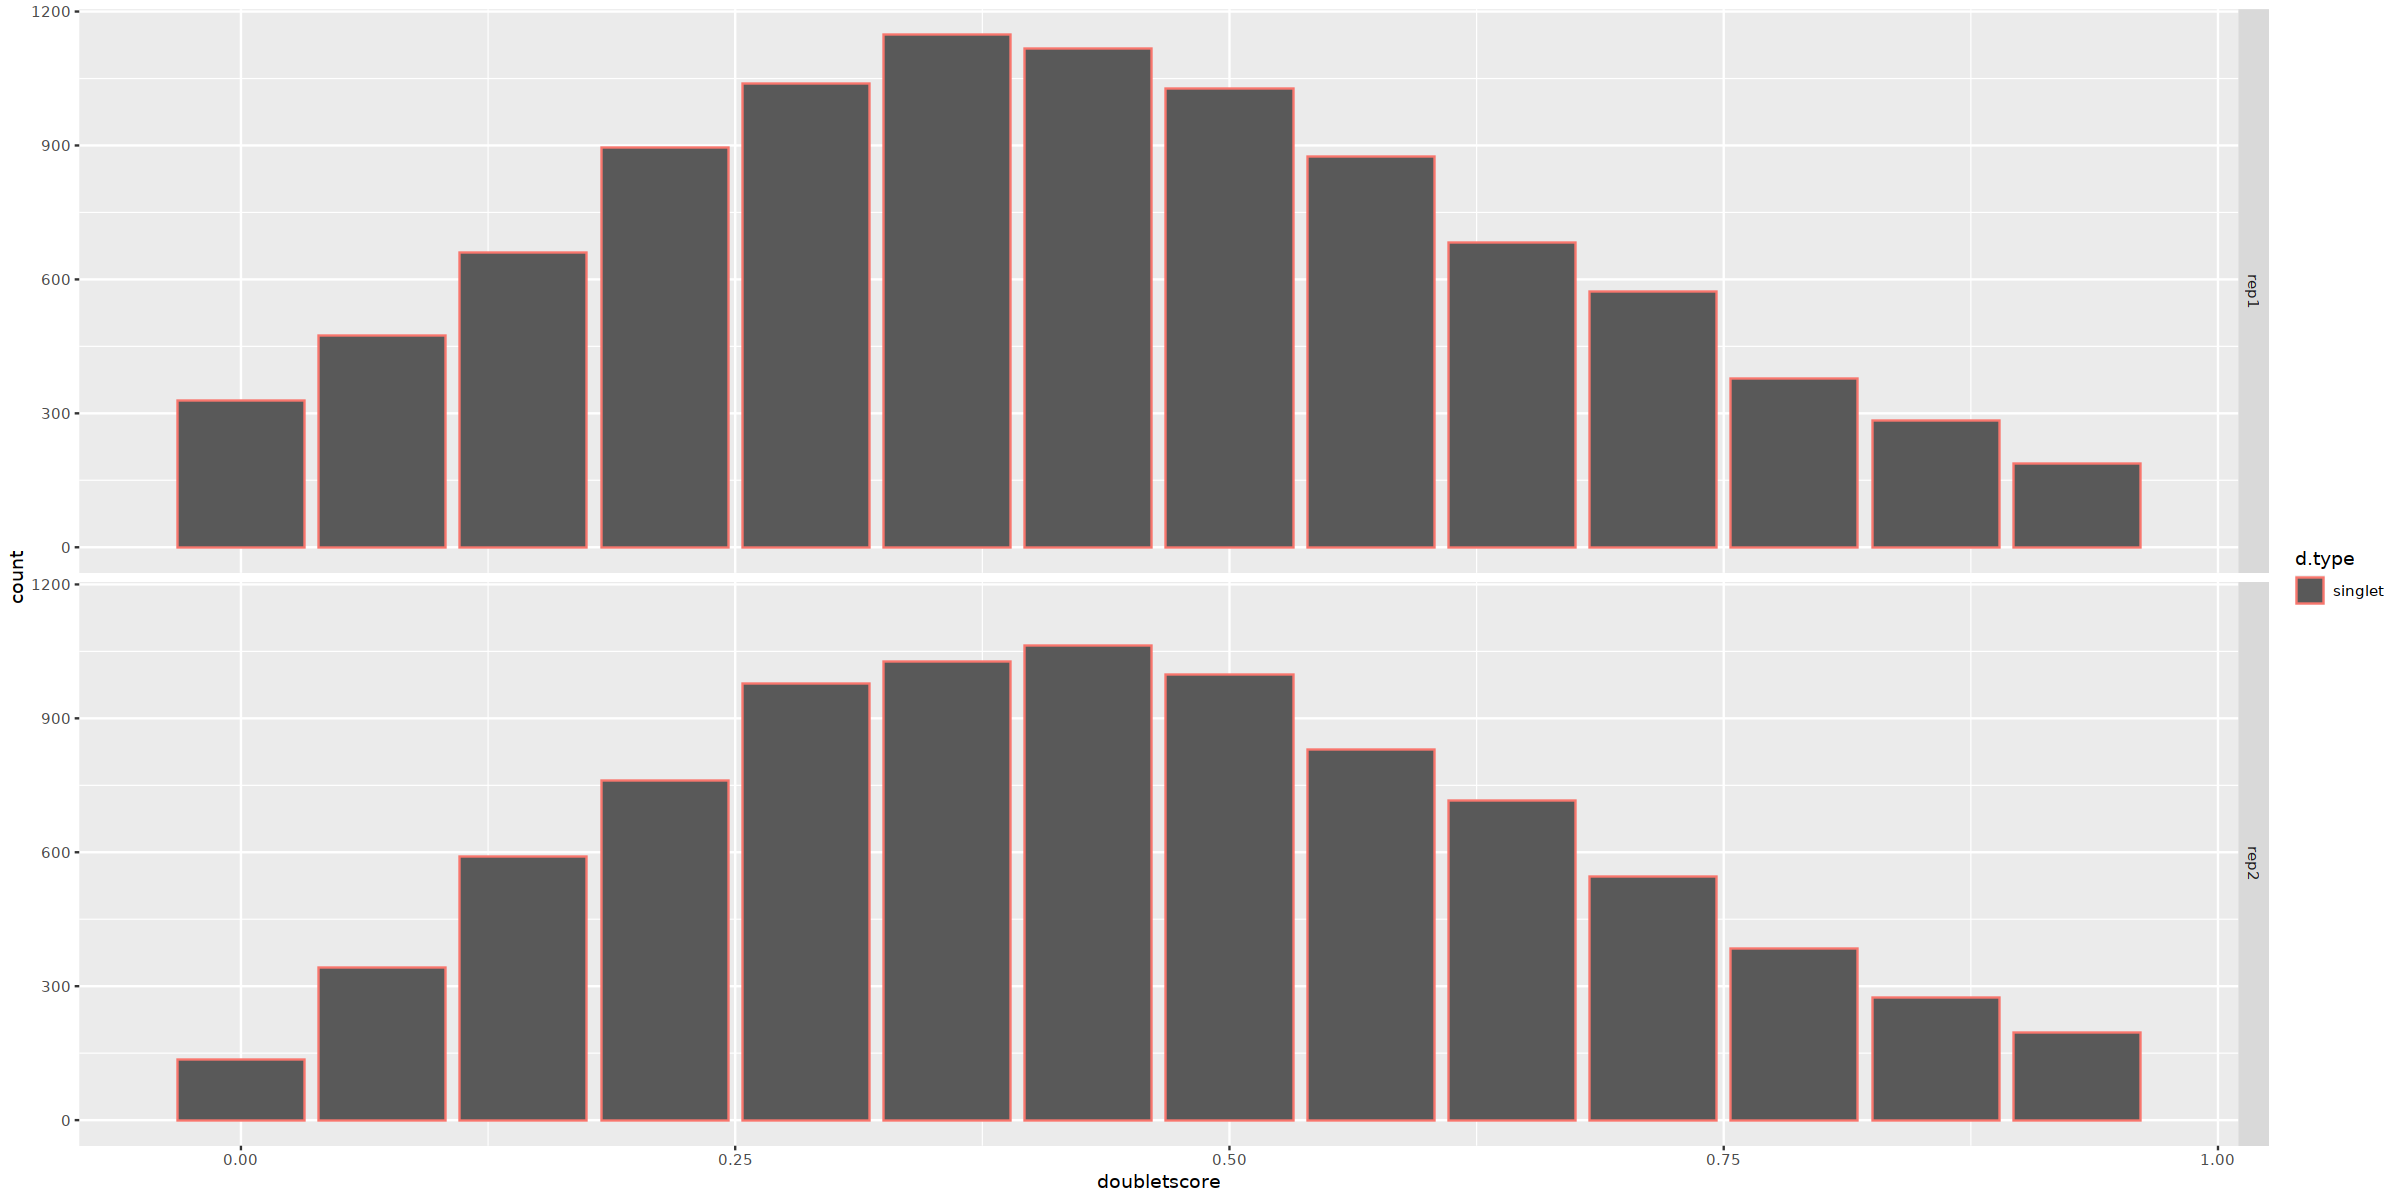

In [25]:
library(tidyverse)
as_tibble(tfidf.obj.dob.filt.removed$meta) %>% 
    ggplot(., aes(doubletscore, color = d.type)) + geom_bar() + facet_grid(sampleID~.)

In [26]:
tfidf.obj.dob.filt.removed.final <- filterDoublets(obj=tfidf.obj.dob.filt, 
                                     filterRatio=1.2, 
                                     removeDoublets=T, 
                                     libraryVar="sampleID",
                                     verbose=TRUE)

 - libraryVar: sampleID

   * Doublet filtering * Input: cells = 20064 | peaks = 239980

   * Doublet filtering * Filtered (12.1%) : cells = 17646 | peaks = 239980



In [27]:
# identify clusters using neighborhood graph -----------------------------
tfidf.obj.dob.filt.clusters <- callClusters(tfidf.obj.dob.filt.removed, 
                        res=2.5,
                        verbose=T,
                        svd_slotName= "SVD",
                        cleanCluster=T)

tfidf.obj.dob.filt.clusters.cleaned <- filterSingle(tfidf.obj.dob.filt.clusters$Clusters, 
            k=10,threshold=3)

tfidf.obj.dob.filt.clusters$Clusters <- tfidf.obj.dob.filt.clusters.cleaned

 - filtering outliers in UMAP manifold (z-score e.thresh = 3) ...

 - creating seurat object for graph-based clustering ...

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 18122
Number of edges: 1561992

Running Louvain algorithm...
Maximum modularity in 100 random starts: 0.7567
Number of communities: 30
Elapsed time: 42 seconds


1 singletons identified. 29 final clusters.

 - finished graph-based clustering ...

   * removing low quality clusters ...

   * filtering per-cluster outliers (z-score filtDistClst2 = 5) ...

   * total number of cells surviving subcluster filtering = 17912

 - filtering clusters with low cell/read counts ...



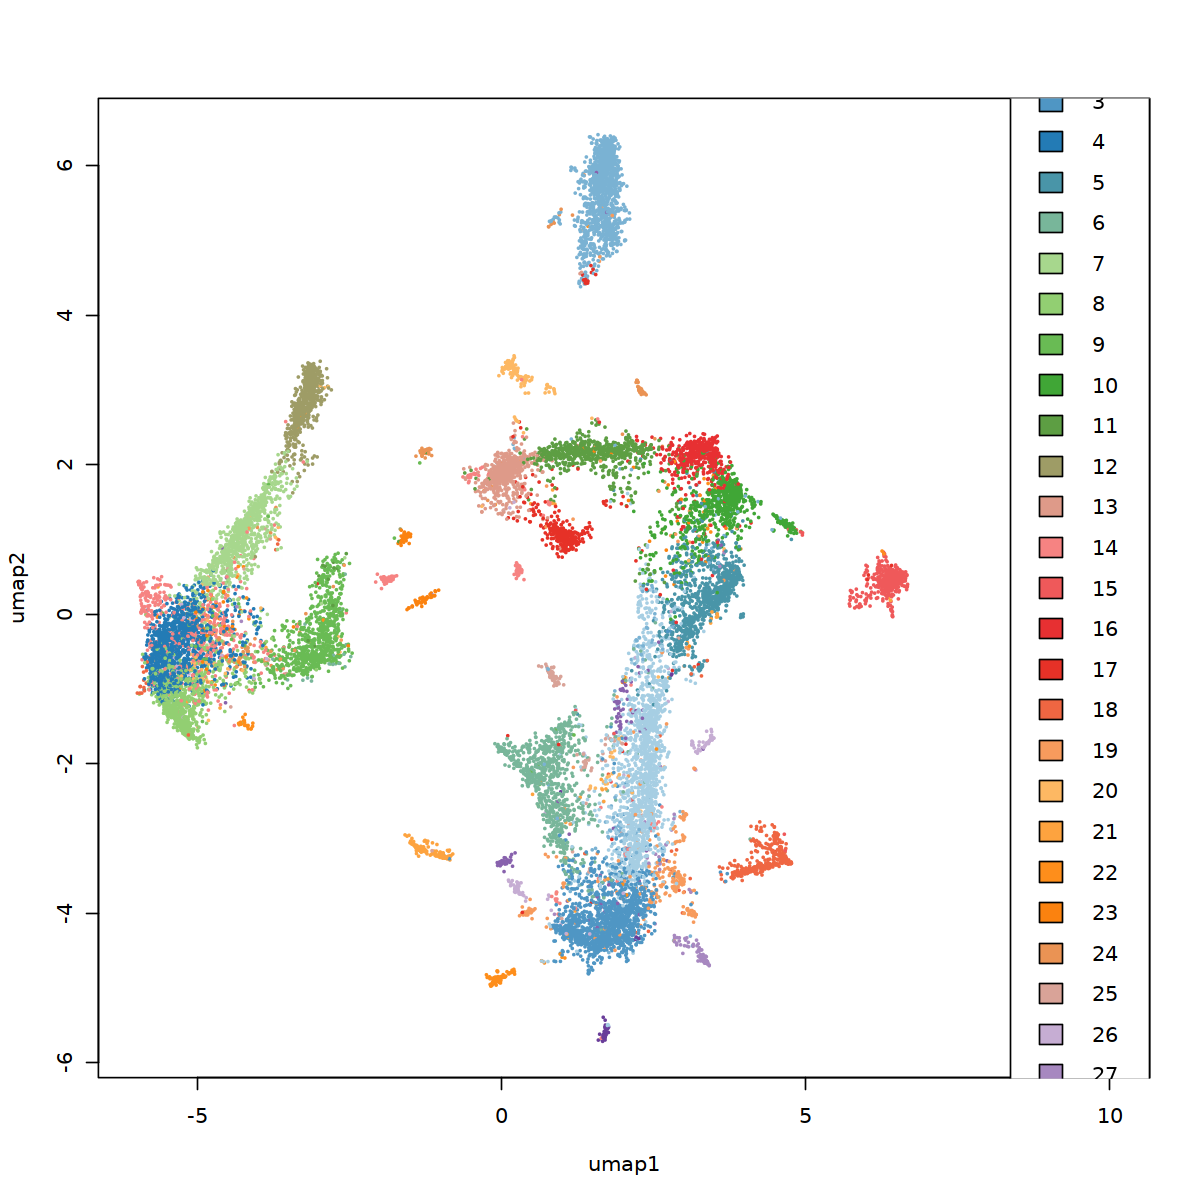

In [28]:
#plot cluster membership on UMAP embedding ------------------------------
options(repr.plot.width=10, repr.plot.height=10)
# NMF
#pdf(paste0(out,".NMF.full.UMAP.clusters.pdf"), width=10, height=10)
plotUMAP(tfidf.obj.dob.filt.clusters, cex=0.3)
#dev.off()

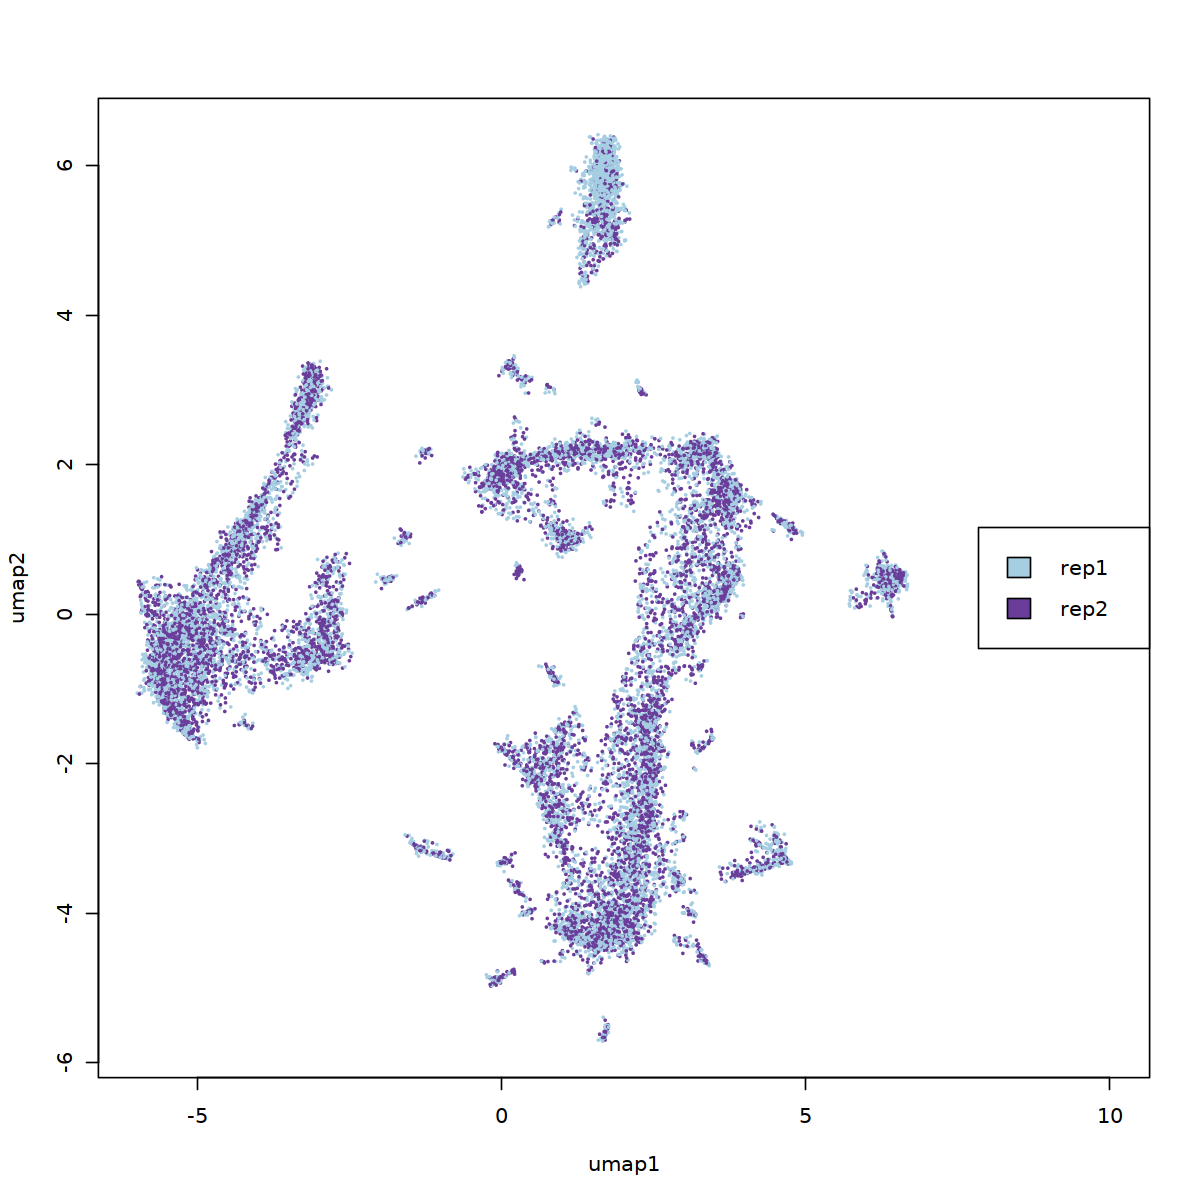

In [29]:
plotUMAP(tfidf.obj.dob.filt.clusters, cex=0.3, column = "sampleID")

In [30]:
as_tibble(tfidf.obj.dob.filt.clusters$Clusters)  %>% 
    group_by(LouvainClusters)  %>% 
    summarise(counts = n())

LouvainClusters counts
1  1               1634  
2  2               1520  
3  3               1470  
4  4               1182  
5  5                973  
6  6                881  
7  7                879  
8  8                838  
9  9                825  
10 10               769  
11 11               727  
12 12               720  
13 13               703  
14 14               649  
15 15               545  
16 16               528  
17 17               382  
18 18               380  
19 19               322  
20 20               241  
21 21               220  
22 22               191  
23 23               179  
24 24               169  
25 25               140  
26 26               137  
27 27               124  
28 28               129  
29 29                80

Rows: 14947 Columns: 25
── Column specification ──────────────────────────────────────────────────────────
Delimiter: "\t"
chr (13): cellID, sampleID, d.type, cell_annotation_glmnet, cell_annotation_...
dbl (12): total, tss, acrs, ptmt, nSites, log10nSites, umap1, umap2, doublet...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


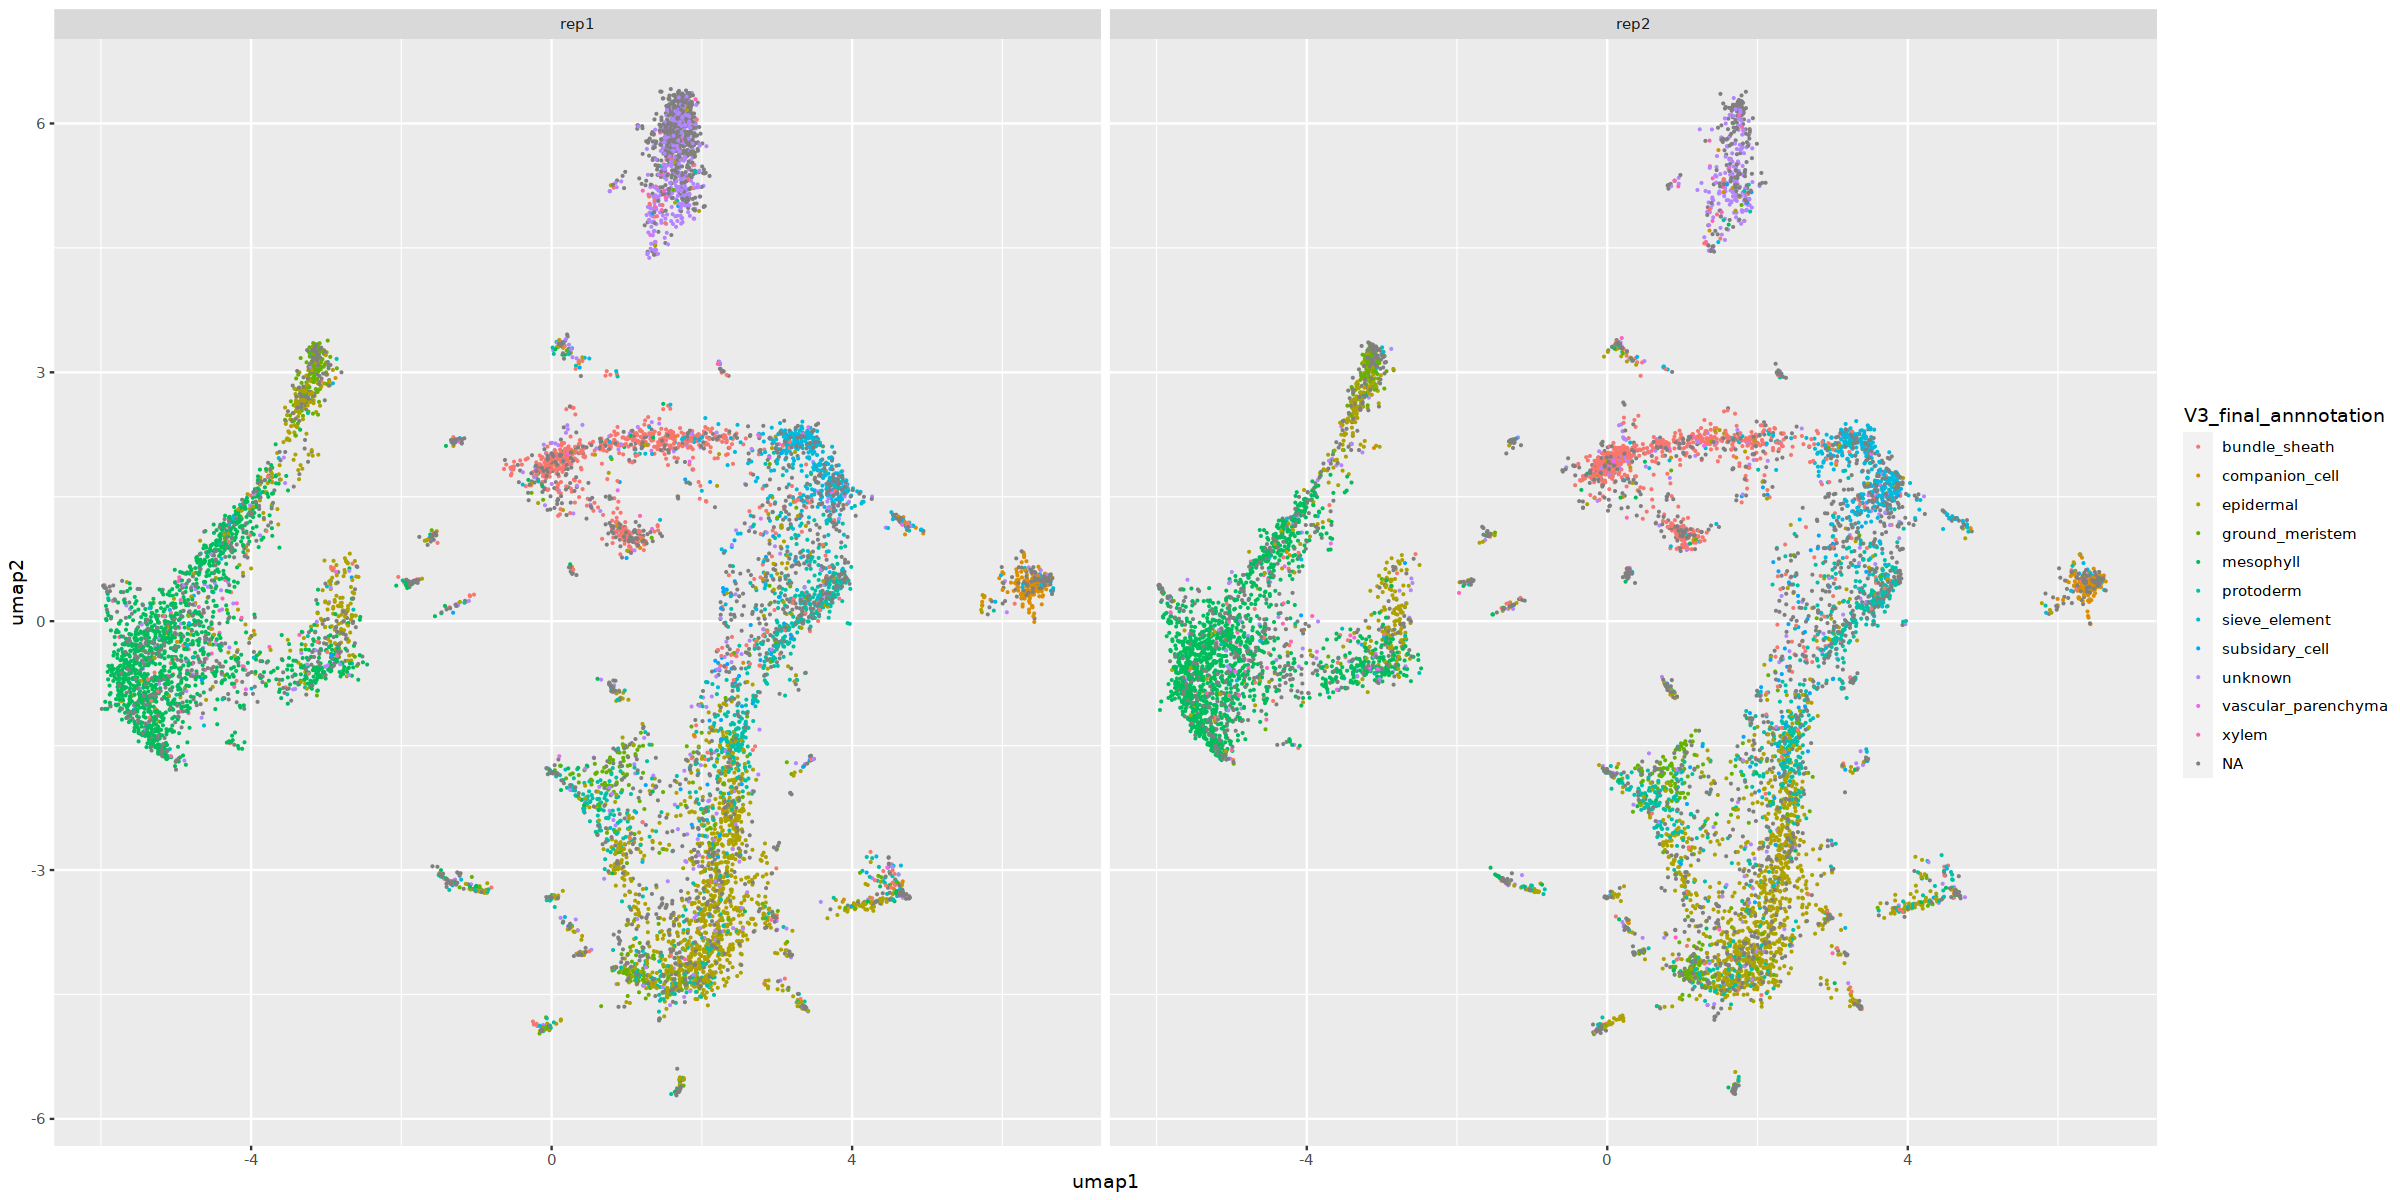

In [31]:
# Copmare with previous Annotation

sb_annotation_v3 <- read_tsv("/home/jpm73279/Mendieta_et_al_comparative_single_cell/metrics/annotations/Sb_leaf.V3_final.txt", 
                                    )
sb_annotation_v3.final <- sb_annotation_v3  %>% 
    dplyr::select(cellID, V3_final_annnotation)

final_combined <- left_join(tfidf.obj.dob.filt.clusters$Clusters, sb_annotation_v3.final, by = "cellID")

options(repr.plot.width=20, repr.plot.height=10)
ggplot(final_combined ,aes(umap1, umap2, color = V3_final_annnotation)) + 
    geom_jitter(size = .1) + facet_grid(.~sampleID)

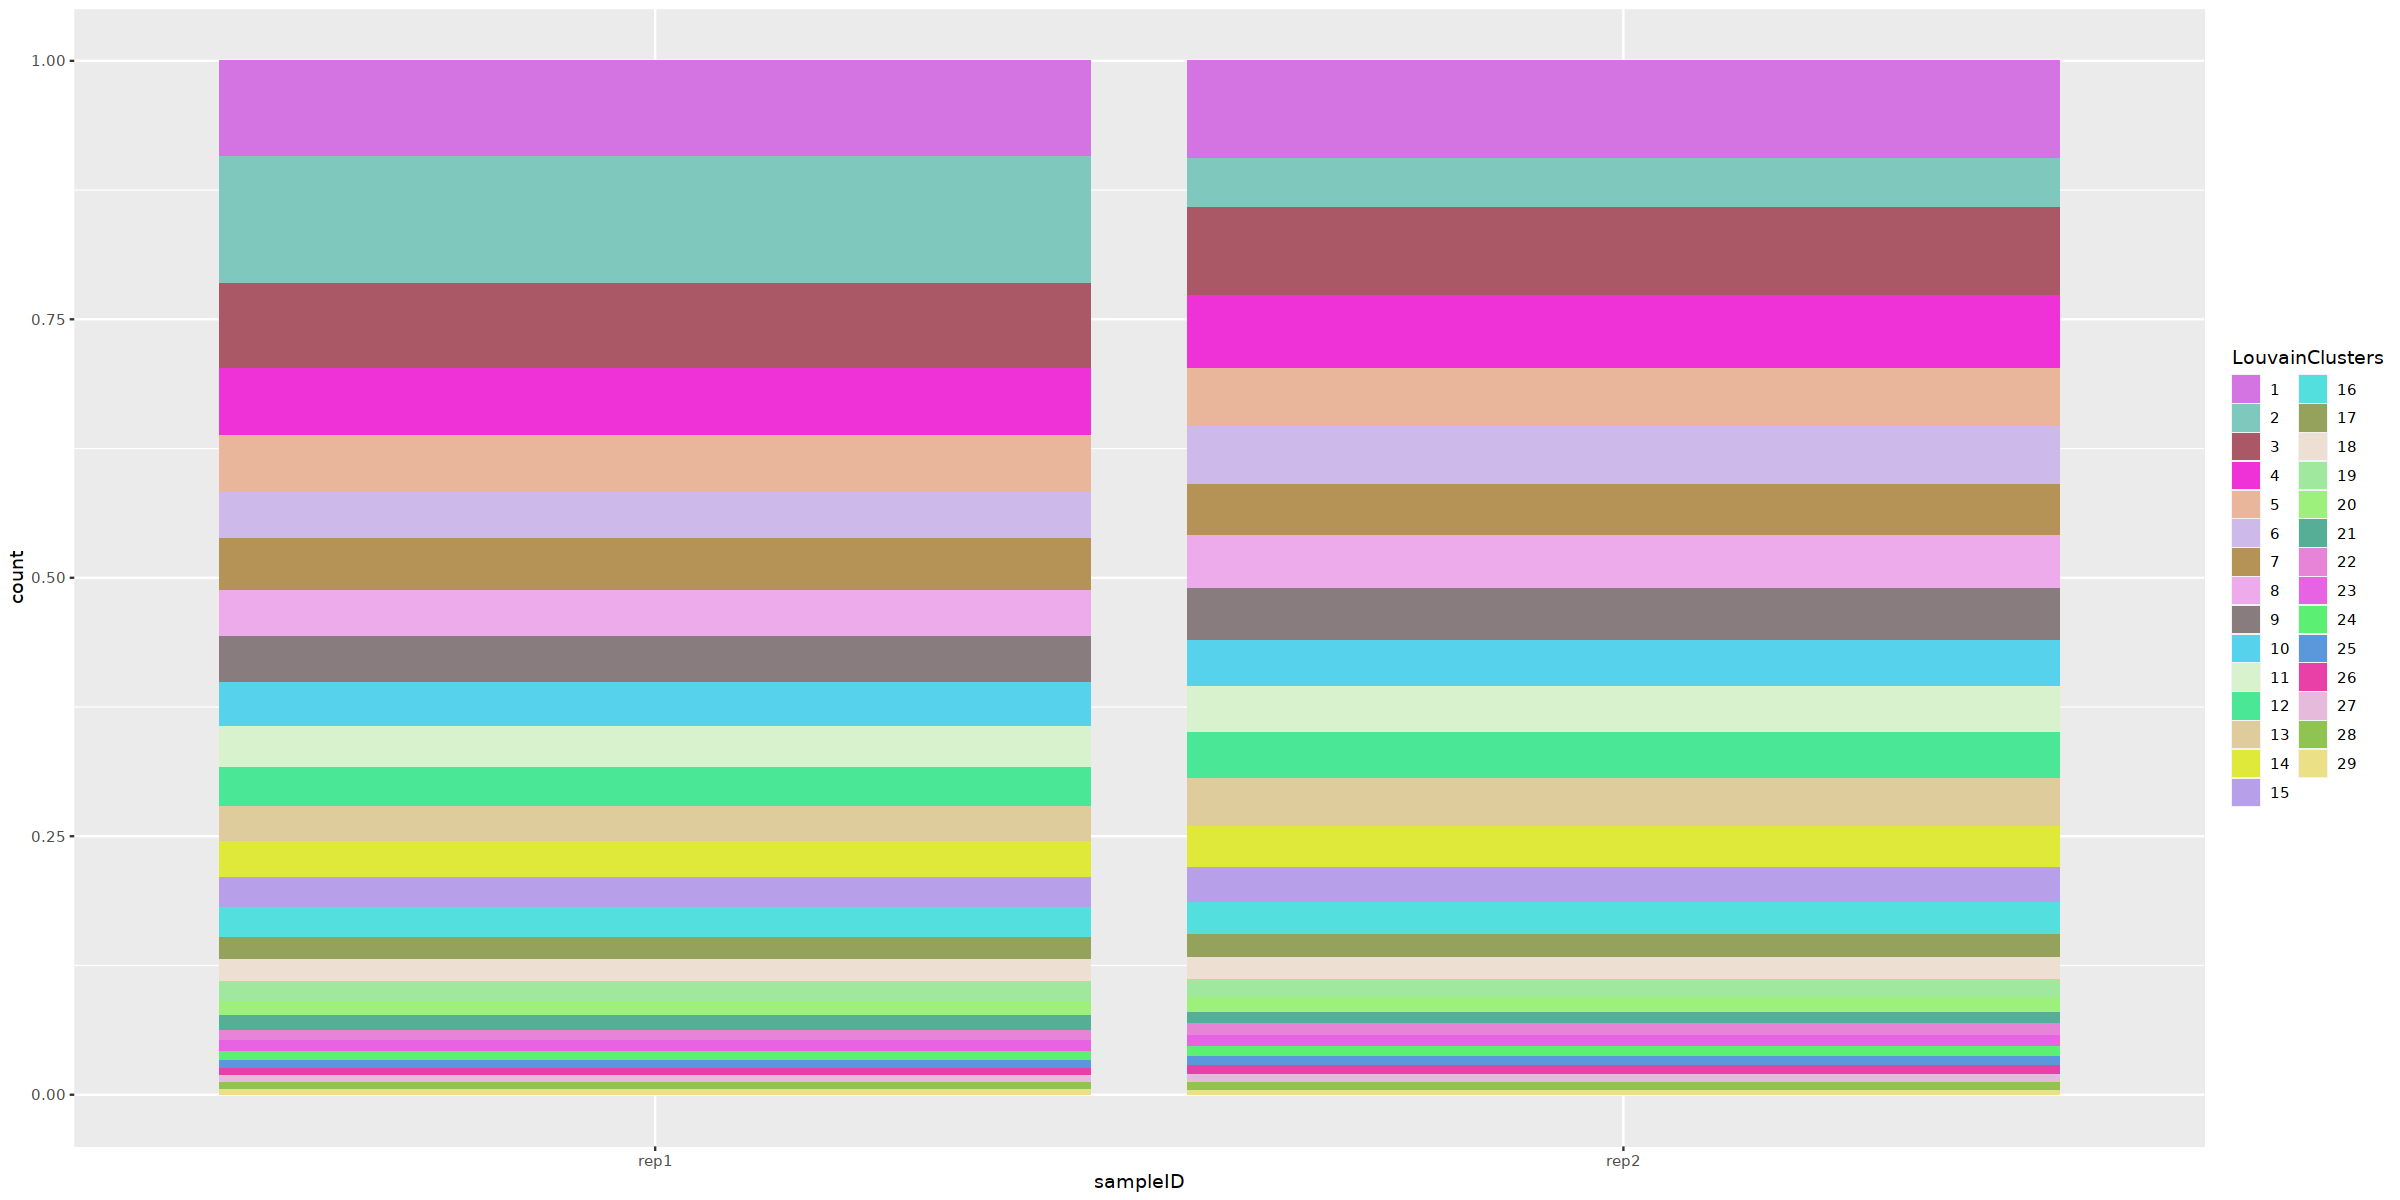

In [32]:
library(RColorBrewer)
other <- randomcoloR::distinctColorPalette(k = 70)
cell_converted_trible <- as_tibble(tfidf.obj.dob.filt.clusters$Clusters)
ggplot(cell_converted_trible,aes(x = sampleID, fill = LouvainClusters)) + 
    geom_bar(position = "fill") + scale_fill_manual(values=other)

In [33]:
#prefix <- "Sb_leaf.merged_replicates"
#output_location <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/clustering/"
#paste0(data_path, prefix,".merged_clusters.sparse")
# output text files
#nmf.meta <- tfidf.obj.dob.filt.clusters$Clusters
#nmf.rd <- tfidf.obj.dob.filt.clusters$NMF

#write.table(nmf.meta, file=paste0(output_location,prefix, ".NMF.full.metadata.txt"), quote=F, row.names=T, col.names=T, sep="\t")
#write.table(nmf.rd, file=paste0(output_location, prefix, ".NMF.full.reduced_dimensions.txt"), quote=F, row.names=T, col.names=T, sep="\t")

In [34]:
#Generate Sparse Matrix-
#trip <- as.data.frame(summary(tfidf.obj.dob.filt.clusters$counts))
#trip$i <- rownames(tfidf.obj.dob.filt.clusters$counts)[trip$i]
#trip$j <- colnames(tfidf.obj.dob.filt.clusters$counts)[trip$j]

#write.table(trip, file=paste0(output_location, prefix, ".NMF.sparse"), quote=F, row.names=T, col.names=T, sep="\t")

### Call Peaks on Current Dataset - and Cluster on Peaks

In [35]:
call_per_cluster_ACRs <- function(meta_obj, 
                                  slot_name, 
                                  cluster_name, 
                                  bed_integrations, 
                                  base_output_name="test_Rrun", 
                                  output_dir="test", 
                                  genome_file,
                                  verbose=FALSE){
    
    clust_name <- c(cluster_name)
    
    cell_converted_trible <- as_tibble(meta_obj[[slot_name]])
    
    
    generate_count_data <- cell_converted_trible  %>% 
        group_by(!!sym(clust_name))  %>% 
        summarise(counts_per_clust = n())
    
    print(generate_count_data)
    
    final_tribble <- left_join(cell_converted_trible, generate_count_data)  %>% 
        mutate(cluster_name_final = str_c(!!sym(clust_name), "_ncell_", counts_per_clust))

    
    write_delim(final_tribble, "test_output_name.2.txt", 
            col_names = TRUE, quote = "none", delim = "\t")

    if(verbose){message("Calling peaks for Clusters - This may take some time. Check output terminal for info.")}
    generate_run_command = paste0("python /home/jpm73279/Mendieta_et_al_comparative_single_cell/python_scripts/scATAC/call_scACRs.py -bed ", bed_integrations, 
                                  " -meta ", "test_output_name.2.txt", 
                                  " -col ", "cluster_name_final", 
                                  " -base ", base_output_name, 
                                  " -outdir ", output_dir, 
                                  " -bw yes -fai ", genome_file)
    
    print(generate_run_command)
    system(generate_run_command)

    
    if(verbose){message("Done!")}
    
    output_peak_file_name <- paste0(output_dir, "/", base_output_name, ".500bp_peaks.bed")
    
    meta_obj$acr_file_name <- output_peak_file_name
    return(meta_obj)
    
}

calculate_accessability <- function(meta_obj, 
                                    tn5_integration, 
                                    base_name="idk",
                                    bed_file_load = "acr_file_name",
                                    type = "acr",
                                    output_name="raw_accessability", 
                                    output_slot = "acr_counts_raw",
                                    output_dir = "."){
    
    peaks <- meta_obj[[bed_file_load]]
    final_output_name <- paste0(output_dir, "/", output_name)
    calculate_accessability <- paste0("python /home/jpm73279/Mendieta_et_al_comparative_single_cell/python_scripts/scATAC/gene_body_acc.py -anno ", peaks, 
                                      " -tn5 ", tn5_integration," -type ", type, " -base ", base_name, " -p 10 -o ", final_output_name) 
    
    
    print(calculate_accessability)
    return_code <- system(calculate_accessability,intern = TRUE)
    
    meta_obj[output_slot] <- output_name
    
    return(meta_obj)
    
}

library(tidyverse)
library(devtools)
library(edgeR)
library('presto')
library(data.table)

library(tidyverse)
library('presto')
library(Matrix)


Loading required package: limma


Attaching package: 'limma'


The following object is masked from 'package:BiocGenerics':

    plotMA


Loading required package: data.table


Attaching package: 'data.table'


The following objects are masked from 'package:dplyr':

    between, first, last


The following object is masked from 'package:purrr':

    transpose


The following object is masked from 'package:slam':

    rollup


The following object is masked from 'package:GenomicRanges':

    shift


The following object is masked from 'package:IRanges':

    shift


The following objects are masked from 'package:S4Vectors':

    first, second




In [36]:
cleaned_cluster <- as_tibble(tfidf.obj.dob.filt.clusters$Clusters)  %>% 
    mutate(LouvainCluster_t = str_c("Louvain_c", LouvainClusters))

In [37]:
tfidf.obj.dob.filt.clusters$Clusters <- cleaned_cluster

In [41]:
setwd("/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/clustering")
bed_intersections <- "/scratch/jpm73279/comparative_single_cell/01.alignments_annotations/sorghum_bicolor/Sorghum_leaf.sciATAC_rep2.unique.tn5.merged.V2.sorted.bed"
genome_file <- "/home/jpm73279/genome_downloads/Sbicolor.v5.1.prelim.annot/Sorghum_bicolor_var_BTx623.chrom.size"

In [40]:
tfidf.obj.dob.filt.clusters <- call_per_cluster_ACRs(tfidf.obj.dob.filt.clusters, 
                                                     slot_name = "Clusters", 
                                                     cluster_name = "LouvainCluster_t",
                                                     bed_integrations = bed_intersections,
                                                     base_output_name = "Sb.V3_annot",
                                                     output_dir = "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/clustering/Sb.Louvain_cluster.iter_1", 
                                                     genome_file= genome_file)

# A tibble: 29 × 2
   LouvainCluster_t counts_per_clust
   <chr>                       <int>
 1 Louvain_c1                   1958
 2 Louvain_c10                   728
 3 Louvain_c11                   703
 4 Louvain_c12                   691
 5 Louvain_c13                   605
 6 Louvain_c14                   539
 7 Louvain_c15                   498
 8 Louvain_c16                   413
 9 Louvain_c17                   379
10 Louvain_c18                   292
# … with 19 more rows


Joining, by = "LouvainCluster_t"


[1] "python /home/jpm73279/Mendieta_et_al_comparative_single_cell/python_scripts/scATAC/call_scACRs.py -bed /scratch/jpm73279/comparative_single_cell/01.alignments_annotations/sorghum_bicolor/Sorghum_leaf.sciATAC_rep2.unique.tn5.merged.V2.sorted.bed -meta test_output_name.2.txt -col cluster_name_final -base Sb.V3_annot -outdir /scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/clustering/Sb.Louvain_cluster.iter_1 -bw yes -fai /home/jpm73279/genome_downloads/Sbicolor.v5.1.prelim.annot/Sorghum_bicolor_var_BTx623.chrom.size"


## Reclustering on ACRs

In [42]:
str(tfidf.obj.dob.filt.clusters)

List of 14
 $ meta            :'data.frame':	18659 obs. of  22 variables:
  ..$ cellID      : chr [1:18659] "BC:Z:ATCACGGGCTACGTATAACTGATACCG-Sorghum_leaf.sciATAC_rep1" "BC:Z:CGATGTAGTCAACTAAGATTCCTACCG-Sorghum_leaf.sciATAC_rep1" "BC:Z:TTAGGCAGTCAACAAAAGGTAGCGTTT-Sorghum_leaf.sciATAC_rep1" "BC:Z:ACAGTGCCGTCCCTAAGGTAGAGAGCT-Sorghum_leaf.sciATAC_rep1" ...
  ..$ total       : num [1:18659] 158695 159913 109649 116717 133880 ...
  ..$ tss         : num [1:18659] 40497 50096 27618 44610 76904 ...
  ..$ acrs        : num [1:18659] 15532 29062 11343 44302 96225 ...
  ..$ ptmt        : num [1:18659] 710 1554 318 998 2016 ...
  ..$ nSites      : num [1:18659] 102298 98398 71779 68519 59662 ...
  ..$ log10nSites : num [1:18659] 5.01 4.99 4.86 4.84 4.78 ...
  ..$ pTSS        : num [1:18659] 0.255 0.313 0.252 0.382 0.574 ...
  ..$ FRiP        : num [1:18659] 0.0979 0.1817 0.1034 0.3796 0.7187 ...
  ..$ pOrg        : num [1:18659] 0.00447 0.00972 0.0029 0.00855 0.01506 ...
  ..$ tss_z       : num [

In [38]:
tfidf.obj.dob.filt.clusters$acr <- read.table("/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/clustering/Sb.Louvain_cluster.iter_1/Sb.V3_annot.500bp_peaks.bed")

In [42]:
tfidf.obj.dob.filt.clusters$bed <- read.table(bed_intersections)

In [73]:

#Save meta data through propogration 
meta_df <- as.data.frame(tfidf.obj.dob.filt.clusters$Clusters)
rownames(meta_df) <- meta_df$cellID
tfidf.obj.dob.filt.clusters$meta.v3 <- meta_df

In [75]:
tfidf.obj.dob.filt.clusters.acrs <- generateMatrix_updated(tfidf.obj.dob.filt.clusters, 
                            filtered=TRUE,
                            peaks=TRUE,
                            organelle_scaffolds= c("Pt", "Mt"),
                            verbose=T)

In [114]:
tfidf.obj.dob.filt.clusters.acrs.sparse <- convertSparseData(tfidf.obj.dob.filt.clusters.acrs)

In [115]:
# clean sparse counts matrix ---------------------------------------------
tfidf.obj.dob.filt.clusters.acrs.sparse <- cleanData(tfidf.obj.dob.filt.clusters.acrs.sparse, 
                     min.c = 25,
                     min.t=0.001,  # minimum feature frequency across cells
                     max.t=0.15, # maximum feature frequency across cells
                     verbose=T)


   * Input: cells = 17537 | peaks = 69892

   * Filtered: cells = 17537 | peaks = 58071



In [116]:
# normalize with TFIDF ---------------------------------------------------
tfidf.obj.dob.filt.clusters.acrs.sparse <- tfidf(tfidf.obj.dob.filt.clusters.acrs.sparse)

In [117]:
# project with NMF -------------------------------------------------------
tfidf.obj.dob.filt.clusters.acrs.sparse <- reduceDims(tfidf.obj.dob.filt.clusters.acrs.sparse,
                      method="SVD", 
                      n.pcs=30, 
                      num.var = 2500,
                      svd_slotName="SVD")

In [118]:
# reduce to 2-dimensions with UMAP ---------------------------------------
tfidf.obj.dob.filt.clusters.acrs.sparse <- projectUMAP(tfidf.obj.dob.filt.clusters.acrs.sparse, 
                       verbose=T,
                       k.near=15,
                       m.dist=0.01,
                       svd_slotName="SVD")
str(tfidf.obj.dob.filt.clusters.acrs.sparse)

library(randomcoloR)
other <- randomcoloR::distinctColorPalette(k = 55)
other <- sample(other)

 - non-linear dimensionality reduction with UMAP ...

10:17:13 UMAP embedding parameters a = 1.896 b = 0.8006

10:17:13 Read 17537 rows and found 30 numeric columns

10:17:13 Using Annoy for neighbor search, n_neighbors = 15

10:17:13 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:17:15 Writing NN index file to temp file /tmp/RtmpU7Bk9j/file1938d5860f337

10:17:15 Searching Annoy index using 16 threads, search_k = 1500

10:17:16 Annoy recall = 99.81%

10:17:20 Commencing smooth kNN distance calibration using 16 threads
 with target n_neighbors = 15

10:17:20 33 smooth knn distance failures

10:17:25 Initializing from normalized Laplacian + noise (using irlba)

10:17:25 Commencing optimization for 200 epochs, with 438022 positive edges

10:17:53 Optimization finishe

List of 10
 $ counts     :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. ..@ i       : int [1:15815280] 0 6 11 18 24 39 47 64 65 80 ...
  .. ..@ p       : int [1:17538] 0 6824 16055 20943 24616 28077 37276 49954 56549 65565 ...
  .. ..@ Dim     : int [1:2] 58071 17537
  .. ..@ Dimnames:List of 2
  .. .. ..$ : chr [1:58071] "Chr01_100016_100517" "Chr01_10004430_10004931" "Chr01_10010583_10011084" "Chr01_10011297_10011798" ...
  .. .. ..$ : chr [1:17537] "BC:Z:ATCACGGGCTACGTATAACTGATACCG-Sorghum_leaf.sciATAC_rep1" "BC:Z:CGATGTAGTCAACTAAGATTCCTACCG-Sorghum_leaf.sciATAC_rep1" "BC:Z:TTAGGCAGTCAACAAAAGGTAGCGTTT-Sorghum_leaf.sciATAC_rep1" "BC:Z:TGACCACTTGTAAAACACGTACGAGCT-Sorghum_leaf.sciATAC_rep1" ...
  .. ..@ x       : num [1:15815280] 1 1 1 1 1 1 1 1 1 1 ...
  .. ..@ factors : list()
 $ meta       :'data.frame':	17537 obs. of  24 variables:
  ..$ cellID          : chr [1:17537] "BC:Z:ATCACGGGCTACGTATAACTGATACCG-Sorghum_leaf.sciATAC_rep1" "BC:Z:CGATGTAGTCAACTAAGATTCCTACCG-Sor

In [119]:
# identify clusters using neighborhood graph -----------------------------
tfidf.obj.dob.filt.clusters.acrs.sparse <- callClusters(tfidf.obj.dob.filt.clusters.acrs.sparse, 
                        res=4,
                        k.near = 15,
                        min.reads=500,
                        verbose=T,
                        svd_slotName= "SVD",
                        cluster_slotName="cluster_acrs",
                        cleanCluster=FALSE)


 - filtering outliers in UMAP manifold (z-score e.thresh = 3) ...

 - creating seurat object for graph-based clustering ...

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 17224
Number of edges: 852269

Running Louvain algorithm...
Maximum modularity in 100 random starts: 0.6490
Number of communities: 31
Elapsed time: 37 seconds


 - finished graph-based clustering ...

 - filtering clusters with low cell/read counts ...



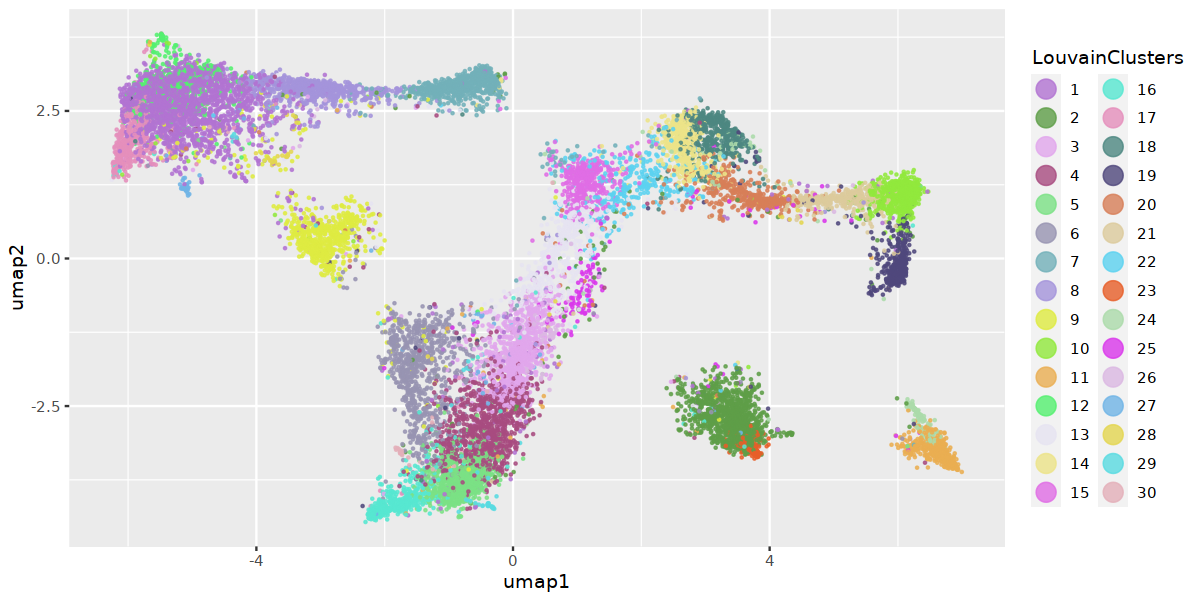

In [120]:
options(repr.plot.width=10, repr.plot.height=5)

ggplot(tfidf.obj.dob.filt.clusters.acrs.sparse$cluster_acrs, aes(x=umap1, y = umap2, color = LouvainClusters)) +
  scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8)

Rows: 14947 Columns: 25
── Column specification ──────────────────────────────────────────────────────────
Delimiter: "\t"
chr (13): cellID, sampleID, d.type, cell_annotation_glmnet, cell_annotation_...
dbl (12): total, tss, acrs, ptmt, nSites, log10nSites, umap1, umap2, doublet...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


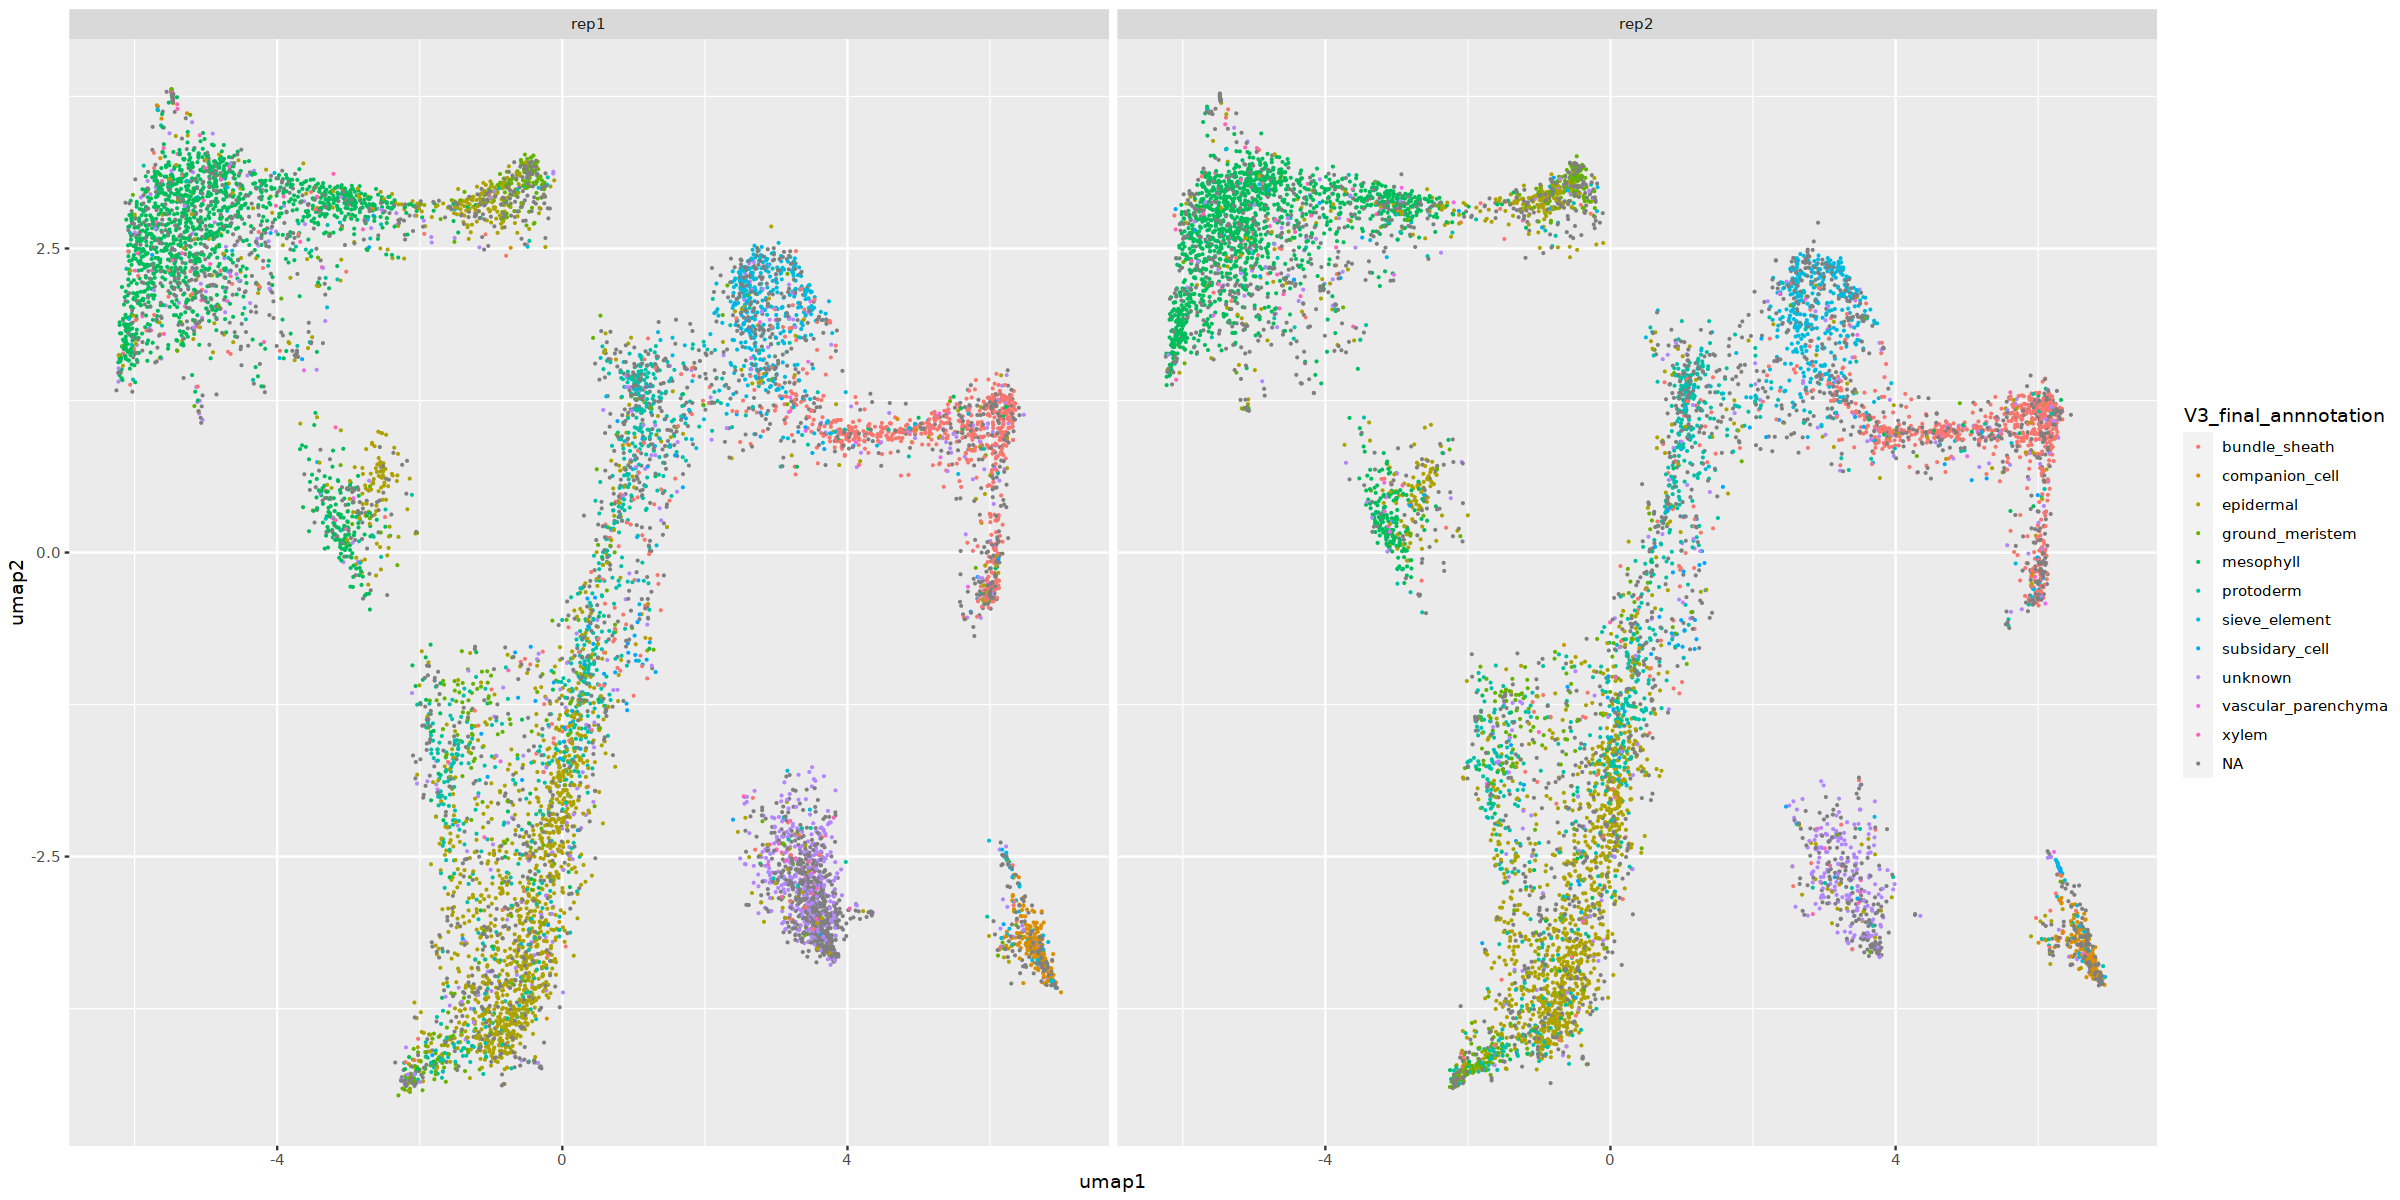

In [121]:
# Copmare with previous Annotation

sb_annotation_v3 <- read_tsv("/home/jpm73279/Mendieta_et_al_comparative_single_cell/metrics/annotations/Sb_leaf.V3_final.txt") 
sb_annotation_v3.final <- sb_annotation_v3  %>% 
    dplyr::select(cellID, V3_final_annnotation)

final_combined <- left_join(tfidf.obj.dob.filt.clusters.acrs.sparse$cluster_acrs, sb_annotation_v3.final, by = "cellID")

options(repr.plot.width=20, repr.plot.height=10)
ggplot(final_combined ,aes(umap1, umap2, color = V3_final_annnotation)) + 
    geom_jitter(size = .1) + facet_grid(.~sampleID)

In [122]:
tfidf.obj.dob.filt.clusters.acrs.sparse$cluster_acrs

cellID                                                    
BC:Z:ATCACGGGCTACGTATAACTGATACCG-Sorghum_leaf.sciATAC_rep1 BC:Z:ATCACGGGCTACGTATAACTGATACCG-Sorghum_leaf.sciATAC_rep1
BC:Z:CGATGTAGTCAACTAAGATTCCTACCG-Sorghum_leaf.sciATAC_rep1 BC:Z:CGATGTAGTCAACTAAGATTCCTACCG-Sorghum_leaf.sciATAC_rep1
BC:Z:TTAGGCAGTCAACAAAAGGTAGCGTTT-Sorghum_leaf.sciATAC_rep1 BC:Z:TTAGGCAGTCAACAAAAGGTAGCGTTT-Sorghum_leaf.sciATAC_rep1
BC:Z:TGACCACTTGTAAAACACGTACGAGCT-Sorghum_leaf.sciATAC_rep1 BC:Z:TGACCACTTGTAAAACACGTACGAGCT-Sorghum_leaf.sciATAC_rep1
BC:Z:TGACCACTTGTAAGCGAGAGTGGCGGT-Sorghum_leaf.sciATAC_rep1 BC:Z:TGACCACTTGTAAGCGAGAGTGGCGGT-Sorghum_leaf.sciATAC_rep1
BC:Z:ACAGTGGGCTACCTAAGGTGAAAACTA-Sorghum_leaf.sciATAC_rep1 BC:Z:ACAGTGGGCTACCTAAGGTGAAAACTA-Sorghum_leaf.sciATAC_rep1
BC:Z:ACAGTGCTTGTACTAAGCGTACGACTA-Sorghum_leaf.sciATAC_rep1 BC:Z:ACAGTGCTTGTACTAAGCGTACGACTA-Sorghum_leaf.sciATAC_rep1
BC:Z:ACAGTGATGTCAACTCGCGTACGACTA-Sorghum_leaf.sciATAC_rep1 BC:Z:ACAGTGATGTCAACTCGCGTACGACTA-Sorghum_leaf.sciATAC_rep1
BC:Z:ATCACGCTTGTAAAACAATGAGCTCGG-Sorghum_leaf.sciATAC_rep1 BC:Z:ATCACGCTTGTAAAACAATGAGCTCGG-Sorghum_leaf.sciATAC_rep1
BC:Z:CGATGTGGCTACATACGGTTTCGTCGG-Sorghum_leaf.sciATAC_rep1 BC:Z:CGATGTGGCTACATACGGTTTCGTCGG-Sorghum_leaf.sciATAC_rep1
BC:Z:TTAGGCCTTGTATTACTGTCCGCCGGT-Sorghum_leaf.sciATAC_rep1 BC:Z:TTAGGCCTTGTATTACTGTCCGCCGGT-Sorghum_leaf.sciATAC_rep1
BC:Z:TTAGGCCTTGTAAGCGAGTTTCGTCGG-Sorghum_leaf.sciATAC_rep1 BC:Z:TTAGGCCTTGTAAGCGAGTTTCGTCGG-Sorghum_leaf.sciATAC_rep1
BC:Z:ACAGTGCTTGTAACTCGACTGATACTA-Sorghum_leaf.sciATAC_rep1 BC:Z:ACAGTGCTTGTAACTCGACTGATACTA-Sorghum_leaf.sciATAC_rep1
BC:Z:GCCAATAGTTCCCTAAGGTTTCGTCGG-Sorghum_leaf.sciATAC_rep1 BC:Z:GCCAATAGTTCCCTAAGGTTTCGTCGG-Sorghum_leaf.sciATAC_rep1
BC:Z:CGATGTATGTCAATACGGTCCGCTCGG-Sorghum_leaf.sciATAC_rep1 BC:Z:CGATGTATGTCAATACGGTCCGCTCGG-Sorghum_leaf.sciATAC_rep1
BC:Z:CGATGTAGTTCCCTAAGATGAGCTCGG-Sorghum_leaf.sciATAC_rep1 BC:Z:CGATGTAGTTCCCTAAGATGAGCTCGG-Sorghum_leaf.sciATAC_rep1
BC:Z:ACAGTGAGTCAATAAGAGTGAAACGAG-Sorghum_leaf.sciATAC_rep1 BC:Z:ACAGTGAGTCAATAAGAGTGAAACGAG-Sorghum_leaf.sciATAC_rep1
BC:Z:TGACCAGGCTACGTGAGGAGTGGTCGG-Sorghum_leaf.sciATAC_rep1 BC:Z:TGACCAGGCTACGTGAGGAGTGGTCGG-Sorghum_leaf.sciATAC_rep1
BC:Z:ATCACGGATCAGAGCGAGGTAGCTCGG-Sorghum_leaf.sciATAC_rep1 BC:Z:ATCACGGATCAGAGCGAGGTAGCTCGG-Sorghum_leaf.sciATAC_rep1
BC:Z:ACAGTGCTTGTAAGCGAGTGAAAACCG-Sorghum_leaf.sciATAC_rep1 BC:Z:ACAGTGCTTGTAAGCGAGTGAAAACCG-Sorghum_leaf.sciATAC_rep1
BC:Z:ATCACGGATCAGCTAAGGGTAGCACCG-Sorghum_leaf.sciATAC_rep1 BC:Z:ATCACGGATCAGCTAAGGGTAGCACCG-Sorghum_leaf.sciATAC_rep1
BC:Z:ATCACGAGTCAAATACGACTGATAGCT-Sorghum_leaf.sciATAC_rep1 BC:Z:ATCACGAGTCAAATACGACTGATAGCT-Sorghum_leaf.sciATAC_rep1
BC:Z:ACAGTGATGTCACTAAGGTGGCCTCGG-Sorghum_leaf.sciATAC_rep1 BC:Z:ACAGTGATGTCACTAAGGTGGCCTCGG-Sorghum_leaf.sciATAC_rep1
BC:Z:TGACCAAGTCAATAAGAGTGGCCAGCT-Sorghum_leaf.sciATAC_rep1 BC:Z:TGACCAAGTCAATAAGAGTGGCCAGCT-Sorghum_leaf.sciATAC_rep1
BC:Z:ACAGTGCTTGTAAAACAATTCCTTCAT-Sorghum_leaf.sciATAC_rep1 BC:Z:ACAGTGCTTGTAAAACAATTCCTTCAT-Sorghum_leaf.sciATAC_rep1
BC:Z:ACAGTGCTTGTAATACGCGTACGTCGG-Sorghum_leaf.sciATAC_rep1 BC:Z:ACAGTGCTTGTAATACGCGTACGTCGG-Sorghum_leaf.sciATAC_rep1
BC:Z:TTAGGCAGTTCCCTAAGGTGGCCACTA-Sorghum_leaf.sciATAC_rep1 BC:Z:TTAGGCAGTTCCCTAAGGTGGCCACTA-Sorghum_leaf.sciATAC_rep1
BC:Z:GCCAATTAGCTTATACGGTGGCCAACA-Sorghum_leaf.sciATAC_rep1 BC:Z:GCCAATTAGCTTATACGGTGGCCAACA-Sorghum_leaf.sciATAC_rep1
BC:Z:TGACCACTTGTAAAACAGTTTCGACCG-Sorghum_leaf.sciATAC_rep1 BC:Z:TGACCACTTGTAAAACAGTTTCGACCG-Sorghum_leaf.sciATAC_rep1
BC:Z:ACAGTGCTTGTAACTCGGTCCGCTCGG-Sorghum_leaf.sciATAC_rep1 BC:Z:ACAGTGCTTGTAACTCGGTCCGCTCGG-Sorghum_leaf.sciATAC_rep1
⋮                                                          ⋮                                                         
BC:Z:GATCAGGGCTACGTAGTCAAAAGCGCG-Sorghum_leaf.sciATAC_rep2 BC:Z:GATCAGGGCTACGTAGTCAAAAGCGCG-Sorghum_leaf.sciATAC_rep2
BC:Z:GGCTACAGTTCCGTGAGGTTTCGTCGG-Sorghum_leaf.sciATAC_rep2 BC:Z:GGCTACAGTTCCGTGAGGTTTCGTCGG-Sorghum_leaf.sciATAC_rep2
BC:Z:GATCAGCTTGTACTAAGGTTTCGAGCT-Sorghum_leaf.s

In [124]:
library("presto")
run_presto <- function(meta_obj, 
                       meta_slot = "Clusters", 
                       cluster_name = "LouvainClusters", 
                       counts_raw="acr_counts_raw"){
    ### Pull the correct meta datafrom the Socrates Object
    sparse_matrix <- meta_obj[[counts_raw]]
    meta_data <- meta_obj[[meta_slot]]
    
    print(head(as_tibble(meta_data)))
        
    ### Read the Giant Sparse Matrix
    loaded_sparse_matric <- read_delim(sparse_matrix, delim='\t', 
                                       col_names = c("gene_name", "barcode", "accessability"), 
                                       col_types = "ccn")
    
    print(head(loaded_sparse_matric))
    combined_large_w_sparse <- loaded_sparse_matric  %>% 
        filter(gene_name != "Annotation")  %>% 
        dplyr::select(gene_name, barcode, accessability)  %>% 
        left_join(., meta_data, by = c("barcode" = "cellID"))  %>% 
        filter(is.na(!!sym(cluster_name)) != TRUE)  %>% 
        arrange(!!sym(cluster_name))
    
    #order <- combined_large_w_sparse[!!sym(cluster_name)]

    combined_large_w_sparse <- combined_large_w_sparse  %>% 
        dplyr::select(gene_name, barcode, accessability)  %>% 
        mutate(across(accessability, as.numeric))
    
    
    gene_names <- unique(combined_large_w_sparse$gene_name)
    barcodes <- unique(combined_large_w_sparse$barcode)

    combined_large_w_sparse$row <- match(combined_large_w_sparse$gene_name, gene_names)
    combined_large_w_sparse$col <- match(combined_large_w_sparse$barcode, barcodes)


    UIMatrix <- sparseMatrix(i = combined_large_w_sparse$row,
                         j = combined_large_w_sparse$col,
                         x = combined_large_w_sparse$accessability,
                         dimnames=list(gene_names, barcodes))

    print(head(tibble(barcode = unlist(UIMatrix@Dimnames[2]))))
    barcode_tibble <- tibble(barcode = unlist(UIMatrix@Dimnames[2])) %>% 
        left_join(., as_tibble(meta_data), by = c("barcode" = "cellID"))  %>% 
        filter(is.na(total) != TRUE)
    
    print(dim(barcode_tibble))
    print(dim(UIMatrix))
    
    clust_name <- c(cluster_name)
    garbbed_louv_order <- pull(barcode_tibble,!!sym(clust_name))

    sparse_matrix_test <- wilcoxauc(UIMatrix, garbbed_louv_order)
    
    meta_obj[["presto_marker"]] <- sparse_matrix_test
    
    return(meta_obj)
}


In [132]:
tfidf.obj.dob.filt.clusters.acrs.sparse$gene_bed_file <- "/home/jpm73279/genome_downloads/Sbicolor.v5.1.prelim.annot/Sbicolorv5.1.gene.bed"
tfidf.obj.dob.filt.clusters.acrs.sparse$gene_acc_counts <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/clustering/Sb.Louvain_cluster.iter_1/sb.gene_accessability.iter_1.scores.txt"

tfidf.obj.dob.filt.clusters.acrs.sparse <- run_presto(tfidf.obj.dob.filt.clusters.acrs.sparse,
           meta_slot = "cluster_acrs",
           counts_raw = "gene_acc_counts",
           cluster_name = "LouvainCluster_t")

# A tibble: 6 × 24
  cellID     total   tss  acrs  ptmt nSites log10…¹  pTSS   FRiP    pOrg   tss_z
  <chr>      <dbl> <dbl> <dbl> <dbl>  <dbl>   <dbl> <dbl>  <dbl>   <dbl>   <dbl>
1 BC:Z:ATC… 158695 40497 15532   710   9909    4.00 0.255 0.0979 0.00447 -0.754 
2 BC:Z:CGA… 159913 50096 29062  1554  13822    4.14 0.313 0.182  0.00972 -0.577 
3 BC:Z:TTA… 109649 27618 11343   318   7337    3.87 0.252 0.103  0.00290 -0.764 
4 BC:Z:TGA…  84033 20453  6146  8047   4909    3.69 0.243 0.0731 0.0958  -0.789 
5 BC:Z:TGA…  77779 21626  6580   584   4784    3.68 0.278 0.0846 0.00751 -0.684 
6 BC:Z:ACA…  85370 44652 46873   831  15716    4.20 0.523 0.549  0.00973  0.0591
# … with 13 more variables: acr_z <dbl>, sites_z <dbl>, qc_check <dbl>,
#   background <dbl>, cellbulk <dbl>, is_cell <dbl>, sampleID <chr>,
#   umap1 <dbl>, umap2 <dbl>, doubletscore <dbl>, d.type <chr>,
#   LouvainClusters <fct>, LouvainCluster_t <chr>, and abbreviated variable
#   name ¹​log10nSites
# A tibble: 6 × 3
  gene_name

In [133]:
marker_list_sb_file <- "/home/jpm73279/genome_downloads/Sbicolor.v5.1.prelim.annot/markers/Sb.leaf_markers_from_zm.markers.txt"
marker_list_sb <- read_delim(marker_list_sb_file, delim='\t', 
                                       col_names = TRUE)

Rows: 151 Columns: 7
── Column specification ──────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): chr, geneID, name, type, tissue
dbl (2): start, end

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [129]:
tfidf.obj.dob.filt.clusters.acrs.sparse$cluster_acrs$LouvainClusters

[1] 2  2  2  2  2  4  25 2  22 3  2  12 2  3  4  5  2  22 5  8  12 9  13 13
   [25] 25 2  5  3  10 3  6  13 2  9  2  2  5  3  21 9  14 8  8  15 18 5  9  25
   [49] 12 5  25 9  12 11 6  2  14 13 2  3  9  3  17 3  13 8  3  22 13 15 12 3 
   [73] 6  10 13 15 5  2  13 11 2  13 6  2  6  9  13 22 2  18 12 9  3  12 2  17
   [97] 11 22 4  8  12 3  22 3  5  10 22 6  5  19 2  9  2  12 25 6  6  3  20 2 
  [121] 3  10 12 10 12 13 16 6  3  9  3  12 22 25 2  3  18 2  22 13 20 10 3  13
  [145] 2  3  3  12 15 2  16 8  13 22 5  21 6  6  10 19 2  3  2  5  16 10 14 15
  [169] 3  3  3  5  5  7  5  8  3  5  22 22 5  25 6  2  6  3  3  5  13 21 21 2 
  [193] 20 20 8  6  8  11 9  2  21 25 12 3  5  14 16 6  21 2  5  22 15 20 6  13
  [217] 12 6  5  15 8  8  5  6  2  16 21 15 13 3  13 9  14 2  6  17 13 13 4  15
  [241] 5  6  2  7  13 10 2  3  14 9  12 25 13 5  9  25 5  21 6  5  6  6  22 6 
  [265] 2  2  5  11 6  12 7  21 21 13 13 20 18 2  10 22 21 3  3  5  2  2  19 2 
  [289] 6  9  8  6  2  9  2  11 13 22 5  3  10 10 7  17 17 6  7  13 5  6  5  13
  [313] 5  13 3  24 5  22 5  3  7  2  6  12 3  22 17 3  9  6  11 14 6  5  4  5 
  [337] 3  9  13 25 6  14 8  3  3  19 18 3  2  14 2  3  4  13 16 22 20 12 11 9 
  [361] 5  21 21 23 2  6  8  2  13 4  7  15 10 13 5  6  2  15 5  3  5  12 10 6 
  [385] 10 15 9  9  12 17 6  12 4  5  8  6  10 5  9  9  6  24 2  9  6  14 21 5 
  [409] 9  15 4  10 6  14 20 8  9  21 13 12 2  12 3  8  20 9  7  4  4  17 3  10
  [433] 10 12 22 9  3  15 3  14 20 12 14 3  22 13 2  3  6  3  7  21 9  18 5  4 
  [457] 5  8  12 3  15 8  14 11 20 5  3  14 2  6  20 13 5  6  5  9  2  5  19 21
  [481] 6  21 6  6  22 4  3  5  21 12 3  5  17 15 6  3  19 9  2  17 4  20 22 2 
  [505] 13 10 10 5  15 15 16 10 2  4  2  25 7  3  10 3  21 9  4  11 5  25 3  4 
  [529] 8  8  5  6  5  15 15 11 5  11 3  24 2  4  25 13 14 14 14 10 12 21 4  5 
  [553] 2  13 8  2  17 11 12 3  3  3  5  21 3  4  9  4  12 7  16 3  3  10 5  4 
  [577] 13 15 19 3  9  12 2  13 3  15 15 6  3  17 7  9  4  3  13 9  9  8  11 9 
  [601] 7  12 12 16 7  2  22 3  12 3  20 18 2  13 10 9  9  7  2  2  5  6  12 17
  [625] 7  18 3  3  3  3  2  21 3  15 8  22 2  14 19 12 22 12 25 5  6  5  2  3 
  [649] 2  4  18 10 3  9  5  5  5  4  16 3  10 5  3  20 2  2  12 15 12 10 14 11
  [673] 8  19 10 8  2  5  18 10 2  12 2  5  3  6  9  2  3  13 10 9  5  5  5  18
  [697] 16 9  22 17 12 2  12 14 3  15 20 16 3  12 12 6  8  9  9  5  12 3  2  16
  [721] 22 21 5  15 5  5  4  16 1  3  12 6  4  5  9  3  15 5  21 17 12 15 6  3 
  [745] 12 4  14 18 14 12 13 6  2  4  20 15 5  5  12 9  14 13 21 17 2  11 17 5 
  [769] 7  10 12 9  4  2  24 19 8  20 10 21 12 12 5  8  10 14 19 10 20 6  2  12
  [793] 5  2  8  6  11 9  3  12 2  2  20 2  6  7  3  13 24 16 14 5  2  10 10 3 
  [817] 19 5  9  13 3  21 16 5  5  8  16 3  6  10 9  9  15 22 21 9  19 13 5  5 
  [841] 21 5  5  8  11 4  3  14 12 12 17 2  12 4  14 19 8  17 14 6  5  2  21 4 
  [865] 15 22 8  5  5  9  2  20 20 8  16 18 12 2  16 12 5  13 18 6  20 21 21 10
  [889] 2  3  3  23 17 13 6  8  8  11 5  5  22 18 6  4  10 15 15 13 13 12 8  4 
  [913] 5  3  2  12 3  8  2  3  2  11 22 16 12 4  6  13 14 5  7  3  2  6  5  9 
  [937] 7  4  15 21 10 2  9  18 2  9  19 5  12 20 14 13 5  2  20 6  4  8  11 12
  [961] 4  9  5  13 3  13 14 25 18 11 4  21 9  5  2  2  12 3  8  13 13 17 11 2 
  [985] 8  19 12 9  2  5  22 3  22 7  17 19 20 9  2  5  9  5  3  2  16 3  20 17
 [1009] 2  12 22 14 25 12 8  5  11 9  3  21 9  18 13 15 24 3  12 5  22 7  2  5 
 [1033] 5  4  8  21 4  23 6  17 14 12 8  22 6  23 2  12 3  20 2  13 12 8  19 3 
 [1057] 10 8  12 3  8  2  15 4  11 17 4  14 5  8  5  3  3  2  11 19 1  20 6  4 
 [1081] 3  2  1  21 14 3  14 8  12 7  13 5  8  6  19 17 5  6  22 3  3  2  6  17
 [1105] 4  2  25 10 20 5  3  22 5  9  9  8  5  2  11 12 3  5  19 8  2  22 5  5 
 [1129] 16 8  17 6  4  21 12 3  9  17 12 6  14 3  3  3  14 12 7  12 3  10 2  6 
 [1153] 13 3  20 8  19 2  1  1  3  6  7  12 5  16 20 2  5  3  3  8  13 18 7  8 
 [1177] 8  24 3  6  14 2  5  9  3  11 18 16 17 9  12 13 11 6  25 10 11 6  15 2 
 [12

In [139]:
colnames(tfidf.obj.dob.filt.clusters.acrs.sparse$cluster_acrs)

[1] "cellID"           "total"            "tss"              "acrs"            
 [5] "ptmt"             "nSites"           "log10nSites"      "pTSS"            
 [9] "FRiP"             "pOrg"             "tss_z"            "acr_z"           
[13] "sites_z"          "qc_check"         "background"       "cellbulk"        
[17] "is_cell"          "sampleID"         "umap1"            "umap2"           
[21] "doubletscore"     "d.type"           "LouvainClusters"  "LouvainCluster_t"

In [140]:
grabbed_top_marker_per_cluster <- top_markers(tfidf.obj.dob.filt.clusters.acrs.sparse$presto_marker, 200)


represented_marker_lst <- list()
for (i in unique(tfidf.obj.dob.filt.clusters.acrs.sparse$cluster_acrs$LouvainCluster_t)) {
    
    make_set <- setNames("geneID",i) 
    markers_present_in_presto <- left_join(grabbed_top_marker_per_cluster, 
                                           marker_list_sb, by = make_set)  %>% 
    dplyr::filter(is.na(chr) != TRUE)  %>% 
    dplyr::select(rank, i, chr:tissue) %>% 
    dplyr::rename("geneID" = i)
    
    represented_marker_lst[[i]] <- markers_present_in_presto
}
                 
represented_marker_lst

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(i)` instead of `i` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.


$Louvain_c2
# A tibble: 0 × 8
# … with 8 variables: rank <int>, geneID <chr>, chr <chr>, start <dbl>,
#   end <dbl>, name <chr>, type <chr>, tissue <chr>

$Louvain_c1
# A tibble: 3 × 8
   rank geneID                chr      start      end name  type          tissue
  <int> <chr>                 <chr>    <dbl>    <dbl> <chr> <chr>         <chr> 
1     1 Sobic.002G207900      Chr02 61233338 61239219 gl1   epidermis     axill…
2    48 Sorbiv5.1_pg9159.m1.g Chr06 41574374 41588764 ba2   axillary_mer… axill…
3   138 Sobic.001G537300      Chr01 84195608 84203525 rld1  SAM,leaf_pri… axill…

$Louvain_c5
# A tibble: 4 × 8
   rank geneID                       chr      start      end name  type   tissue
  <int> <chr>                        <chr>    <dbl>    <dbl> <chr> <chr>  <chr> 
1    40 Sobic.001G221900             Chr01 21229983 21235639 ad1   proto… axill…
2    51 Sorbiv5.1_pg14938.valid.m7.g Chr03  8560607  8567782 ocl1  proto… axill…
3   135 Sobic.002G032500             Chr02  3002965  3011531 pan2  subsi… axill…
4   174 Sobic.001G499200             Chr01 81035681 81040362 nod   stoma… axill…

$Louvain_c4
# A tibble: 3 × 8
   rank geneID                        chr      start      end name  type  tissue
  <int> <chr>                         <chr>    <dbl>    <dbl> <chr> <chr> <chr> 
1     1 Sobic.010G160700              Chr10 48834723 48842334 pepc1 meso… axill…
2     2 Sorbiv5.1_pg15362.valid.m24.g Chr03 63610236 63623676 cah1  meso… axill…
3    36 Sobic.005G042000              Chr05  3935393  3936843 ssu2… bund… axill…

$Louvain_c3
# A tibble: 4 × 8
   rank geneID                 chr      start      end name         type  tissue
  <int> <chr>                  <chr>    <dbl>    <dbl> <chr>        <chr> <chr> 
1     1 Sobic.002G207900       Chr02 61233338 61239219 gl1          epid… axill…
2    87 Sobic.001G537300       Chr01 84195608 84203525 rld1         SAM,… axill…
3   163 Sorbiv5.1_pg15531.m1.g Chr03  3341071  3347117 me3_ortho_c… bund… axill…
4   190 Sobic.009G162000       Chr09 55658168 55661565 gpat11__gpa… epid… axill…

$Louvain_c9
# A tibble: 3 × 8
   rank geneID                        chr      start      end name  type  tissue
  <int> <chr>                         <chr>    <dbl>    <dbl> <chr> <chr> <chr> 
1    25 Sorbiv5.1_pg15362.valid.m24.g Chr03 63610236 63623676 cah1  meso… axill…
2    40 Sobic.010G160700              Chr10 48834723 48842334 pepc1 meso… axill…
3    71 Sorbiv5.1_pg9159.m1.g         Chr06 41574374 41588764 ba2   axil… axill…

$Louvain_c13
# A tibble: 3 × 8
   rank geneID                 chr      start      end name         type  tissue
  <int> <chr>                  <chr>    <dbl>    <dbl> <chr>        <chr> <chr> 
1    28 Sobic.005G042000       Chr05  3935393  3936843 ssu2__ssu1   bund… axill…
2   122 Sobic.007G141200       Chr07 60395810 60403219 ccr1         vasc… axill…
3   194 Sorbiv5.1_pg15531.m1.g Chr03  3341071  3347117 me3_ortho_c… bund… axill…

$Louvain_c6
# A tibble: 3 × 8
   rank geneID                 chr      start      end name         type  tissue
  <int> <chr>                  <chr>    <dbl>    <dbl> <chr>        <chr> <chr> 
1     3 Sobic.002G207900       Chr02 61233338 61239219 gl1          epid… axill…
2   165 Sobic.001G537300       Chr01 84195608 84203525 rld1         SAM,… axill…
3   192 Sorbiv5.1_pg15531.m1.g Chr03  3341071  3347117 me3_ortho_c… bund… axill…

$Louvain_c16
# A tibble: 1 × 8
   rank geneID           chr      start      end name  type               tissue
  <int> <chr>            <chr>    <dbl>    <dbl> <chr> <chr>              <chr> 
1   168 Sobic.007G211200 Chr07 67406141 67408727 pan1  subsidary_mother_… axill…

$Louvain_c7
# A tibble: 6 × 8
   rank geneID                        chr      start      end name  type  tissue
  <int> <chr>                         <chr>    <dbl>    <dbl> <chr> <chr> <chr> 
1     1 Sobic.010G160700              Chr10 48834723 48842334 pepc1 meso… axill…
2     9 Sobic.005G042000              Chr05  3935393  3936843 ssu2… bund… axill…
3

In [143]:
gathered_markers <- bind_rows(represented_marker_lst, .id = "LouvainCluster")  %>% 
    arrange(LouvainCluster, rank)


In [144]:
write_delim(gathered_markers, 
            "/home/jpm73279/Mendieta_et_al_comparative_single_cell/metrics/annotations/V3_annotations/Sb_leaf.merged_replicates.QC_V2.presto.txt", 
            col_names = TRUE, quote = "none", delim = "\t")

gathered_markers

LouvainCluster rank geneID                        chr   start    end     
1  Louvain_c1       1  Sobic.002G207900              Chr02 61233338 61239219
2  Louvain_c1      48  Sorbiv5.1_pg9159.m1.g         Chr06 41574374 41588764
3  Louvain_c1     138  Sobic.001G537300              Chr01 84195608 84203525
4  Louvain_c10     38  Sobic.002G032500              Chr02  3002965  3011531
5  Louvain_c10    135  Sorbiv5.1_pg7389.valid.m23.g  Chr06 60678690 60686342
6  Louvain_c10    140  Sobic.001G145200              Chr01 11750927 11755977
7  Louvain_c10    187  Sorbiv5.1_pg4404.valid.m2.g   Chr01 75069835 75073435
8  Louvain_c11      6  Sorbiv5.1_pg9159.m1.g         Chr06 41574374 41588764
9  Louvain_c11     10  Sobic.007G141200              Chr07 60395810 60403219
10 Louvain_c11     20  Sobic.005G042000              Chr05  3935393  3936843
11 Louvain_c12     97  Sobic.001G499200              Chr01 81035681 81040362
12 Louvain_c12    189  Sorbiv5.1_pg24873.valid.m3.g  Chr02  2529322  2534592
13 Louvain_c13     28  Sobic.005G042000              Chr05  3935393  3936843
14 Louvain_c13    122  Sobic.007G141200              Chr07 60395810 60403219
15 Louvain_c13    194  Sorbiv5.1_pg15531.m1.g        Chr03  3341071  3347117
16 Louvain_c14      1  Sobic.010G160700              Chr10 48834723 48842334
17 Louvain_c15     45  Sorbiv5.1_pg26238.m1.g        Chr02 19991876 19997282
18 Louvain_c15     53  Sorbiv5.1_pg29247.valid.m13.g Chr09 53708860 53712249
19 Louvain_c15    141  Sobic.004G058700              Chr04  4774060  4777174
20 Louvain_c15    155  Sobic.001G488700              Chr01 80047831 80054246
21 Louvain_c16    168  Sobic.007G211200              Chr07 67406141 67408727
22 Louvain_c17     28  Sobic.002G083600              Chr02  8962876  8967240
23 Louvain_c17    107  Sobic.001G327900              Chr01 65660828 65664161
24 Louvain_c17    115  Sobic.007G141200              Chr07 60395810 60403219
25 Louvain_c17    143  Sorbiv5.1_pg1793.valid.m1.g   Chr01 13056142 13064330
26 Louvain_c18      3  Sobic.002G207900              Chr02 61233338 61239219
27 Louvain_c18    123  Sorbiv5.1_pg5044.valid.m7.g   Chr01 66616555 66619678
28 Louvain_c18    188  Sorbiv5.1_pg18563.valid.m1.g  Chr07  6900132  6906079
29 Louvain_c21     99  Sobic.004G348800              Chr04 70314888 70316188
30 Louvain_c21    161  Sorbiv5.1_pg15070.valid.m5.g  Chr03 75641869 75645490
⋮  ⋮              ⋮    ⋮                             ⋮     ⋮        ⋮       
33 Louvain_c24     98  Sobic.003G274000              Chr03 67334256 67337044
34 Louvain_c27     46  Sobic.008G171100              Chr08 63608809 63612638
35 Louvain_c27    160  Sorbiv5.1_pg10021.valid.m1.g  Chr10  8474616  8475832
36 Louvain_c28     38  Sobic.007G003000              Chr07   278193   279964
37 Louvain_c28    136  Sobic.006G279400              Chr06 62388932 62391254
38 Louvain_c3       1  Sobic.002G207900              Chr02 61233338 61239219
39 Louvain_c3      87  Sobic.001G537300              Chr01 84195608 84203525
40 Louvain_c3     163  Sorbiv5.1_pg15531.m1.g        Chr03  3341071  3347117
41 Louvain_c3     190  Sobic.009G162000              Chr09 55658168 55661565
42 Louvain_c4       1  Sobic.010G160700              Chr10 48834723 48842334
43 Louvain_c4       2  Sorbiv5.1_pg15362.valid.m24.g Chr03 63610236 63623676
44 Louvain_c4      36  Sobic.005G042000              Chr05  3935393  3936843
45 Louvain_c5      40  Sobic.001G221900              Chr01 21229983 21235639
46 Louvain_c5      51  Sorbiv5.1_pg14938.valid.m7.g  Chr03  8560607  8567782
47 Louvain_c5     135  Sobic.002G032500              Chr02  3002965  3011531
48 Louvain_c5     174  Sobic.001G499200              Chr01 81035681 81040362
49 Louvain_c6       3  Sobic.002G207900              Chr02 61233338 61239219
50 Louvain_c6     165  Sobic.001G537300              Chr01 84195608 84203525
51 Louvain_c6     192  Sorbiv5.1_pg15531.m1.g        Chr03  3341071  3347117
52 Louvain_c7       1  Sobic.010G160700              Chr10 48834723 48842334

In [145]:
prefix <- "Sb_leaf.merged_replicates.QC_V2"
output_location <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/clustering/"

In [148]:
tfidf.obj.dob.filt.clusters.acrs.sparse$cluster_acrs$Louvain_cluster_safe <- tfidf.obj.dob.filt.clusters.acrs.sparse$cluster_acrs$LouvainCluster_t

In [149]:
tfidf.obj.dob.filt.clusters.acrs.sparse$cluster_acrs

cellID                                                    
BC:Z:ATCACGGGCTACGTATAACTGATACCG-Sorghum_leaf.sciATAC_rep1 BC:Z:ATCACGGGCTACGTATAACTGATACCG-Sorghum_leaf.sciATAC_rep1
BC:Z:CGATGTAGTCAACTAAGATTCCTACCG-Sorghum_leaf.sciATAC_rep1 BC:Z:CGATGTAGTCAACTAAGATTCCTACCG-Sorghum_leaf.sciATAC_rep1
BC:Z:TTAGGCAGTCAACAAAAGGTAGCGTTT-Sorghum_leaf.sciATAC_rep1 BC:Z:TTAGGCAGTCAACAAAAGGTAGCGTTT-Sorghum_leaf.sciATAC_rep1
BC:Z:TGACCACTTGTAAAACACGTACGAGCT-Sorghum_leaf.sciATAC_rep1 BC:Z:TGACCACTTGTAAAACACGTACGAGCT-Sorghum_leaf.sciATAC_rep1
BC:Z:TGACCACTTGTAAGCGAGAGTGGCGGT-Sorghum_leaf.sciATAC_rep1 BC:Z:TGACCACTTGTAAGCGAGAGTGGCGGT-Sorghum_leaf.sciATAC_rep1
BC:Z:ACAGTGGGCTACCTAAGGTGAAAACTA-Sorghum_leaf.sciATAC_rep1 BC:Z:ACAGTGGGCTACCTAAGGTGAAAACTA-Sorghum_leaf.sciATAC_rep1
BC:Z:ACAGTGCTTGTACTAAGCGTACGACTA-Sorghum_leaf.sciATAC_rep1 BC:Z:ACAGTGCTTGTACTAAGCGTACGACTA-Sorghum_leaf.sciATAC_rep1
BC:Z:ACAGTGATGTCAACTCGCGTACGACTA-Sorghum_leaf.sciATAC_rep1 BC:Z:ACAGTGATGTCAACTCGCGTACGACTA-Sorghum_leaf.sciATAC_rep1
BC:Z:ATCACGCTTGTAAAACAATGAGCTCGG-Sorghum_leaf.sciATAC_rep1 BC:Z:ATCACGCTTGTAAAACAATGAGCTCGG-Sorghum_leaf.sciATAC_rep1
BC:Z:CGATGTGGCTACATACGGTTTCGTCGG-Sorghum_leaf.sciATAC_rep1 BC:Z:CGATGTGGCTACATACGGTTTCGTCGG-Sorghum_leaf.sciATAC_rep1
BC:Z:TTAGGCCTTGTATTACTGTCCGCCGGT-Sorghum_leaf.sciATAC_rep1 BC:Z:TTAGGCCTTGTATTACTGTCCGCCGGT-Sorghum_leaf.sciATAC_rep1
BC:Z:TTAGGCCTTGTAAGCGAGTTTCGTCGG-Sorghum_leaf.sciATAC_rep1 BC:Z:TTAGGCCTTGTAAGCGAGTTTCGTCGG-Sorghum_leaf.sciATAC_rep1
BC:Z:ACAGTGCTTGTAACTCGACTGATACTA-Sorghum_leaf.sciATAC_rep1 BC:Z:ACAGTGCTTGTAACTCGACTGATACTA-Sorghum_leaf.sciATAC_rep1
BC:Z:GCCAATAGTTCCCTAAGGTTTCGTCGG-Sorghum_leaf.sciATAC_rep1 BC:Z:GCCAATAGTTCCCTAAGGTTTCGTCGG-Sorghum_leaf.sciATAC_rep1
BC:Z:CGATGTATGTCAATACGGTCCGCTCGG-Sorghum_leaf.sciATAC_rep1 BC:Z:CGATGTATGTCAATACGGTCCGCTCGG-Sorghum_leaf.sciATAC_rep1
BC:Z:CGATGTAGTTCCCTAAGATGAGCTCGG-Sorghum_leaf.sciATAC_rep1 BC:Z:CGATGTAGTTCCCTAAGATGAGCTCGG-Sorghum_leaf.sciATAC_rep1
BC:Z:ACAGTGAGTCAATAAGAGTGAAACGAG-Sorghum_leaf.sciATAC_rep1 BC:Z:ACAGTGAGTCAATAAGAGTGAAACGAG-Sorghum_leaf.sciATAC_rep1
BC:Z:TGACCAGGCTACGTGAGGAGTGGTCGG-Sorghum_leaf.sciATAC_rep1 BC:Z:TGACCAGGCTACGTGAGGAGTGGTCGG-Sorghum_leaf.sciATAC_rep1
BC:Z:ATCACGGATCAGAGCGAGGTAGCTCGG-Sorghum_leaf.sciATAC_rep1 BC:Z:ATCACGGATCAGAGCGAGGTAGCTCGG-Sorghum_leaf.sciATAC_rep1
BC:Z:ACAGTGCTTGTAAGCGAGTGAAAACCG-Sorghum_leaf.sciATAC_rep1 BC:Z:ACAGTGCTTGTAAGCGAGTGAAAACCG-Sorghum_leaf.sciATAC_rep1
BC:Z:ATCACGGATCAGCTAAGGGTAGCACCG-Sorghum_leaf.sciATAC_rep1 BC:Z:ATCACGGATCAGCTAAGGGTAGCACCG-Sorghum_leaf.sciATAC_rep1
BC:Z:ATCACGAGTCAAATACGACTGATAGCT-Sorghum_leaf.sciATAC_rep1 BC:Z:ATCACGAGTCAAATACGACTGATAGCT-Sorghum_leaf.sciATAC_rep1
BC:Z:ACAGTGATGTCACTAAGGTGGCCTCGG-Sorghum_leaf.sciATAC_rep1 BC:Z:ACAGTGATGTCACTAAGGTGGCCTCGG-Sorghum_leaf.sciATAC_rep1
BC:Z:TGACCAAGTCAATAAGAGTGGCCAGCT-Sorghum_leaf.sciATAC_rep1 BC:Z:TGACCAAGTCAATAAGAGTGGCCAGCT-Sorghum_leaf.sciATAC_rep1
BC:Z:ACAGTGCTTGTAAAACAATTCCTTCAT-Sorghum_leaf.sciATAC_rep1 BC:Z:ACAGTGCTTGTAAAACAATTCCTTCAT-Sorghum_leaf.sciATAC_rep1
BC:Z:ACAGTGCTTGTAATACGCGTACGTCGG-Sorghum_leaf.sciATAC_rep1 BC:Z:ACAGTGCTTGTAATACGCGTACGTCGG-Sorghum_leaf.sciATAC_rep1
BC:Z:TTAGGCAGTTCCCTAAGGTGGCCACTA-Sorghum_leaf.sciATAC_rep1 BC:Z:TTAGGCAGTTCCCTAAGGTGGCCACTA-Sorghum_leaf.sciATAC_rep1
BC:Z:GCCAATTAGCTTATACGGTGGCCAACA-Sorghum_leaf.sciATAC_rep1 BC:Z:GCCAATTAGCTTATACGGTGGCCAACA-Sorghum_leaf.sciATAC_rep1
BC:Z:TGACCACTTGTAAAACAGTTTCGACCG-Sorghum_leaf.sciATAC_rep1 BC:Z:TGACCACTTGTAAAACAGTTTCGACCG-Sorghum_leaf.sciATAC_rep1
BC:Z:ACAGTGCTTGTAACTCGGTCCGCTCGG-Sorghum_leaf.sciATAC_rep1 BC:Z:ACAGTGCTTGTAACTCGGTCCGCTCGG-Sorghum_leaf.sciATAC_rep1
⋮                                                          ⋮                                                         
BC:Z:GATCAGGGCTACGTAGTCAAAAGCGCG-Sorghum_leaf.sciATAC_rep2 BC:Z:GATCAGGGCTACGTAGTCAAAAGCGCG-Sorghum_leaf.sciATAC_rep2
BC:Z:GGCTACAGTTCCGTGAGGTTTCGTCGG-Sorghum_leaf.sciATAC_rep2 BC:Z:GGCTACAGTTCCGTGAGGTTTCGTCGG-Sorghum_leaf.sciATAC_rep2
BC:Z:GATCAGCTTGTACTAAGGTTTCGAGCT-Sorghum_leaf.s

In [ ]:


# output text files
nmf.meta <- tfidf.obj.dob.filt.clusters.acrs.sparse$cluster_acrs
nmf.rd <- tfidf.obj.dob.filt.clusters.acrs.sparse$SVD

write.table(nmf.meta, file=paste0(output_location,prefix, ".SVD.full.metadata.txt"), quote=F, row.names=T, col.names=T, sep="\t")
write.table(nmf.rd, file=paste0(output_location, prefix, ".SVD.full.reduced_dimensions.txt"), quote=F, row.names=T, col.names=T, sep="\t")


#Generate Sparse Matrix-
trip <- as.data.frame(summary(tfidf.obj.dob.filt.clusters.acrs.sparse$counts))
trip$i <- rownames(tfidf.obj.dob.filt.clusters.acrs.sparse$counts)[trip$i]
trip$j <- colnames(tfidf.obj.dob.filt.clusters.acrs.sparse$counts)[trip$j]

write.table(trip, file=paste0(output_location, prefix, ".SVD.sparse"), quote=F, row.names=T, col.names=T, sep="\t")

In [146]:
saveRDS(tfidf.obj.dob.filt.clusters.acrs.sparse, file = paste0(output_location, prefix, ".rds"))